#### PSD e IIA

# QRS detector
#### Francisco Maiocchi

***
### Introducción

Este notebook prueba distintos modelos de red para la detección de latidos en un ECG. El paquete de Python llamado WFDB (https://github.com/MIT-LCP/wfdb-python) da acceso a los datasets de https://physionet.org/physiobank/database/#ecg. En este ejemplo se utiliza la base de datos QT.  

Esta base de datos cuenta con 105 registros de ECG de dos canales cada uno y una frecuencia de muestreo de 250 Hz. Cada registro consta de tres archivos que brindan distinto tipo de información. Algunos registros fueron descartados ya que las anotaciones no eran coherentes, quedando un total de 82 registros.

Para alimentar las redes, se dividió cada registro en ventanas de un ancho fijo por lo que cada ejemplo es un array de 512 muestras. Como técnica de data augmentation, las ventanas son solapadas un 75% aumentando asi el número de ejemplos. 

Los target tienen la misma cantidad de muestras que los datos de entrada (512). Constan de un vector de ceros y una ventana de Hamming de 36 muestras por cada anotación del registro. Esto mejoro los resultados obtenidos con targets del tipo one-hot encoder.

De los 82 registros utilizados, se seleccionaron aleatoriamente 58 para el set de entrenamiento, 12 para el set de validación y 12 para el set de testeo.

Por otro lado, los datasets se normalizaron. A cada ejemplo de entrada se le restó el valor medio y se lo dividió por el desvío estandard tal cual propone el paper _Deep learning based QRS Multilead Delineator in Electrocardiogram signals_. Los labels estan normalizados para que el pico de la ventana de Hamming tenga valor unitario.

***
### Imports

In [1]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from IPython.display import HTML
import os
from glob import glob
import urllib3
import pandas as pd
from bs4 import BeautifulSoup as BSoup
import h5py
import wfdb as wf
from scipy import signal as signal

print(tf.__version__)


1.12.0


### Definiciones

+ width: es el ancho de la ventana

In [2]:
# Tamaño de la ventana en cantidad de muestras
window_width = 512
# Overlapping de ventanas en % 
overlapping = 75

### Funciones utilizadas

In [3]:
def download_db():
    
    extensions = ['atr', 'dat', 'hea']
    the_path = 'https://www.physionet.org/physiobank/database/qtdb/'
    
    # Guardo en data/
    savedir = 'data/qtdb'
    # Si no existe la carpeta, la creo
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    # Formato de guardado
    savename = savedir + '/{}.{}'

    # Encuentro todos los archivos importantes del sitio
    http = urllib3.PoolManager()
    response = http.request('GET', the_path)
    soup = BSoup(response.data)

    # Encuentro todos los links a archivos .dat 
    hrefs = []
    for a in soup.find_all('a', href=True):
        href = a['href']
        # Descargo los archivos con los marcadores dados
        if href[-4::] == '.dat':
            hrefs.append(href[:-4])
        
    # Path al archivo en internet
    down_path = the_path + '{}.{}'

    for data_id in hrefs:
        for ext in extensions:
            webpath = down_path.format(data_id, ext)
            http = urllib3.PoolManager()
            datafile = http.request('GET', webpath)

            # Guardo localmente
            filepath = savename.format(data_id, ext)
            with open(filepath, 'wb') as out:
                out.write(datafile.data)
    
    print ('Se descargaron ' + str(len(hrefs)) + ' archivos de datos')

def get_records():

    # Descargo si no existe
    if not os.path.isdir('data/qtdb'):
        print ('Descargando qtdb ecg database...')
        download_db()
        print ('Descarga terminada')
        
    # Hay 3 archivos por record
    # *.atr es uno de ellos
    paths = glob('data/qtdb/*.atr')

    # Elimino la extensión
    paths = [path[:-4] for path in paths]
    # Ordena la lista ascendentemente
    paths.sort()

    return paths

def get_beats(annotation):

    types = np.array(annotation.symbol)
    
    beat_symbols = ['N', 'L', 'R', 'B', 'A',
        'a', 'J', 'S', 'V', 'r',
        'F', 'e', 'j', 'n', 'E',
        '/', 'f', 'Q', '?']
    
    ids = np.in1d(annotation.symbol, beat_symbols)

    # Me quedo con las posiciones
    beats = annotation.sample[ids]

    return beats

def convert_input(channel, beats):
    # Me quedo con todo los latidos

    # Creo una señal con one-hot encoding
    dirac = np.zeros_like(channel)
    dirac[beats] = 1.0

    # Uso la ventana de hamming para la campana
    width = 36
    filter = signal.hamming(width)
    gauss = np.convolve(filter, dirac, mode = 'same')

    return dirac, gauss

def make_dataset(records, width, savepath):

    signals, labels = [], []

    # Recorro los archivos
    for path in records:
        print ('Processing file:' + path)
        data, field = wf.rdsamp(path)
        annotations = wf.rdann(path, 'atr')

        # Convierto cada canal en datos y labels
        signal, label = convert_data(data, annotations, width)

        # Acumulo
        signals.append(signal)
        labels.append(label)

    # Convierto todo en un np.array
    signals = np.vstack(signals)
    labels = np.vstack(labels)
    
    # Me quedo unicamente con los labels de ventana de Hamming
    labels = labels[:, 1, :]

    # Guardo en forma de diccionario
    np.save(savepath, {'signals' : signals,
                       'labels'  : labels })

def convert_data(data, annotations, width):
    
    signals, labels = [], []
    
    beats = get_beats(annotations)

    # Convierto ambos canales
    for it in range(2):
        channel = data[:, it]
        dirac, gauss = convert_input(channel, beats)
        # Junto los labels
        label = np.vstack([dirac, gauss])

        # Ventana movil
        sta = 0
        end = width
        # overlapping
        stride = int(width*(100 - overlapping)/100)
        
        while end <= len(channel):
            # Me quedo con una ventana
            s_frag = channel[sta : end]
            l_frag = label[:, sta : end]

            # Acumulo
            signals.append(s_frag)
            labels.append(l_frag)

            # Paso a la ventana siguiente
            sta += stride
            end += stride

    # Convierto a np.array
    signals = np.array(signals)
    labels = np.array(labels)

    return signals, labels

def create_datasets():

    # Preparo los archivos
    records = get_records()

    # Mezclo los archivos
    np.random.seed(666)
    np.random.shuffle(records)

    # Tamaño de la ventana
    width = window_width

    # Armo el set de entrenamiento con el 70% de los registros 
    make_dataset(records[:58], width, 'data/training')

    # Armo el set de validacion con el 15% de los registros
    make_dataset(records[58 : 70], width, 'data/validation')

    # Armo el set de testeo  con el 15% de los registros
    make_dataset(records[70 : 82], width, 'data/test')

### Creación del dataset 

In [7]:
create_datasets()

Processing file:data/qtdb\sel811


NameError: name 'ss' is not defined

### Cargar datasets

In [4]:
# Cargo el set de entrenamiento
train_path = 'data/training.npy'
training_set = np.load(train_path)[()]

# Normalizo los datos de entrenamiento
train_input = training_set.get('signals')
train_input = (train_input - np.mean(train_input, axis = 1,  keepdims = True)) / (np.std(train_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

train_label = training_set.get('labels')

# Cargo el set de validación
validation_path = 'data/validation.npy'
validation_set = np.load(validation_path)[()]

# Normalizo los datos de validación
validation_input = validation_set.get('signals')
validation_input = (validation_input - np.mean(validation_input, axis = 1,  keepdims = True)) / (np.std(validation_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

validation_label = validation_set.get('labels')

# Cargo el set de test
test_path = 'data/test.npy'
test_set = np.load(test_path)[()]

# Normalizo los datos de testeo
test_input = test_set.get('signals')
test_input = (test_input - np.mean(test_input, axis = 1,  keepdims = True)) / (np.std(test_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

test_label = test_set.get('labels')

# Definiciones para más adelante
examples = np.random.randint(np.size(test_input,0), size = 10) # Se utiliza para sacar 10 ejemplos al azar del set de entrenamiento

***
### Modelo 1


##### Arquitectura

In [6]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 510, 16)           64        
_________________________________________________________________
batch_normalization (BatchNo (None, 510, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 510, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_1 (Batch (None, 508, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 508, 16)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 254, 16)           0         
__________

##### Configuración de red

In [7]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'binary_crossentropy',      
              metrics = ['mae', 'mse', 'accuracy'])  

##### Entrenamiento

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model1.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 441s 2ms/step - loss: 0.1430 - mean_absolute_error: 0.0586 - mean_squared_error: 0.0206 - acc: 0.8238 - val_loss: 0.1196 - val_mean_absolute_error: 0.0412 - val_mean_squared_error: 0.0142 - val_acc: 0.8372
Epoch 2/1000
203464/203464 [==============================] - 429s 2ms/step - loss: 0.1280 - mean_absolute_error: 0.0490 - mean_squared_error: 0.0159 - acc: 0.8246 - val_loss: 0.1212 - val_mean_absolute_error: 0.0422 - val_mean_squared_error: 0.0145 - val_acc: 0.8367
Epoch 3/1000
203464/203464 [==============================] - 425s 2ms/step - loss: 0.1251 - mean_absolute_error: 0.0470 - mean_squared_error: 0.0150 - acc: 0.8247 - val_loss: 0.1203 - val_mean_absolute_error: 0.0399 - val_mean_squared_error: 0.0135 - val_acc: 0.8373
Epoch 4/1000
203464/203464 [==============================] - 429s 2ms/step - loss: 0.1241 - mean_absolute_error: 0.0464 - mean_squared_error: 0.

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

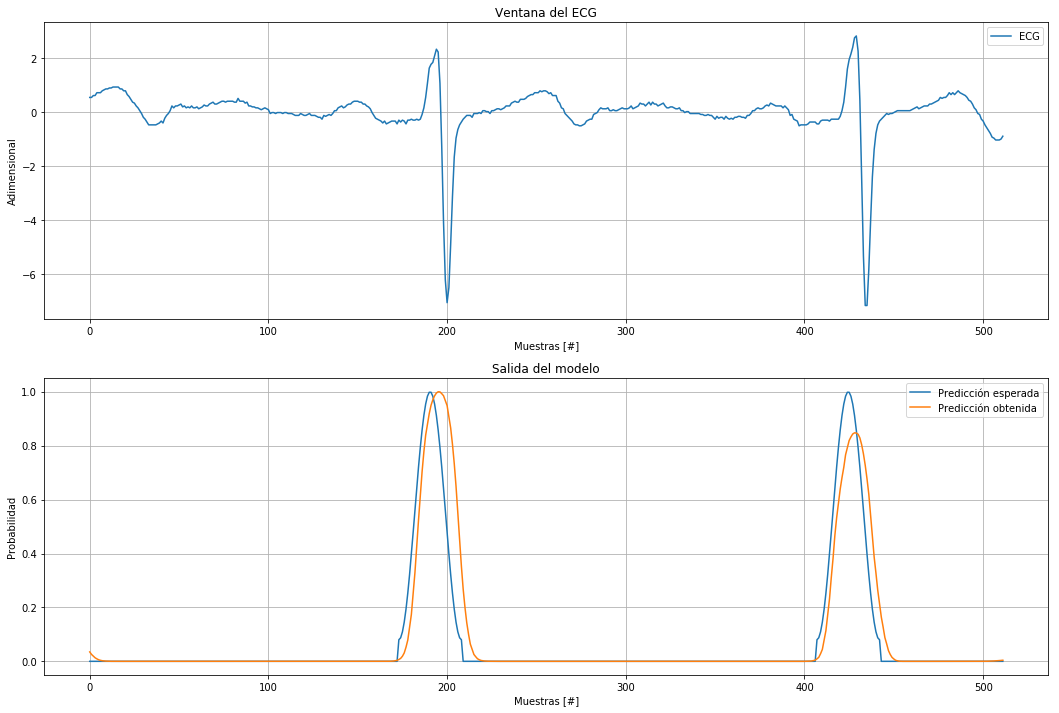

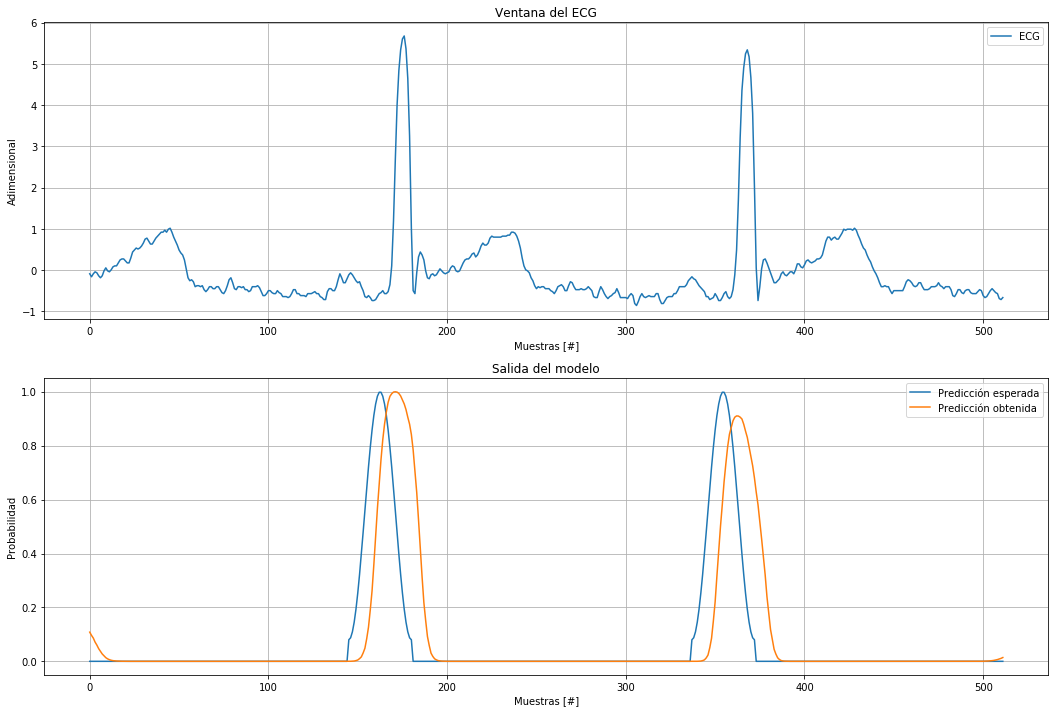

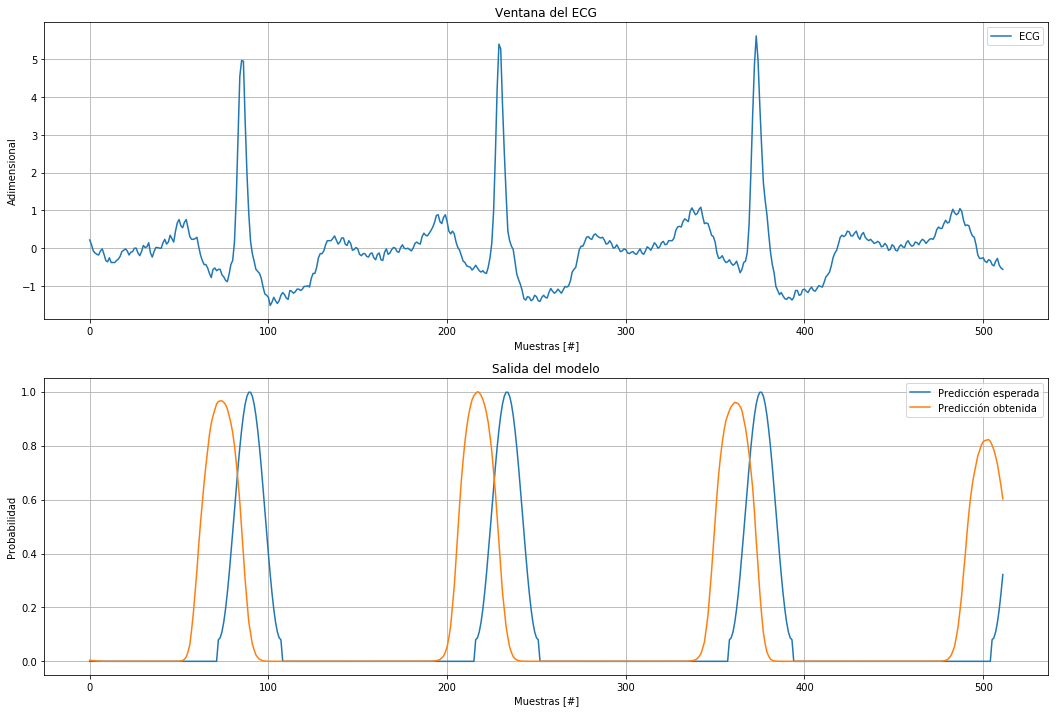

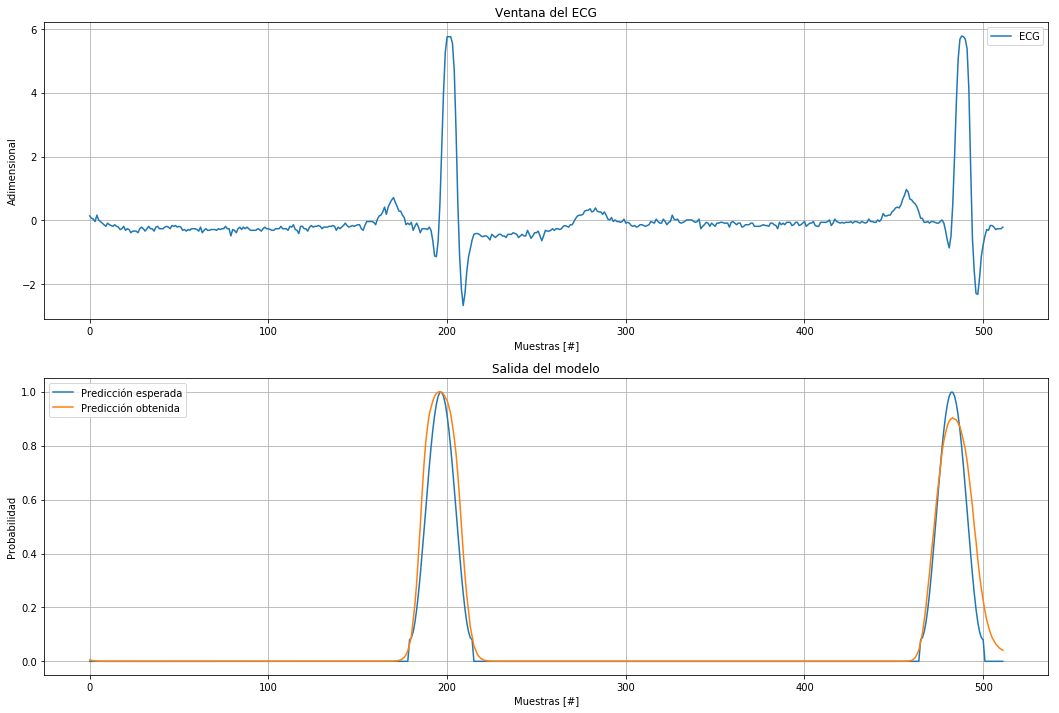

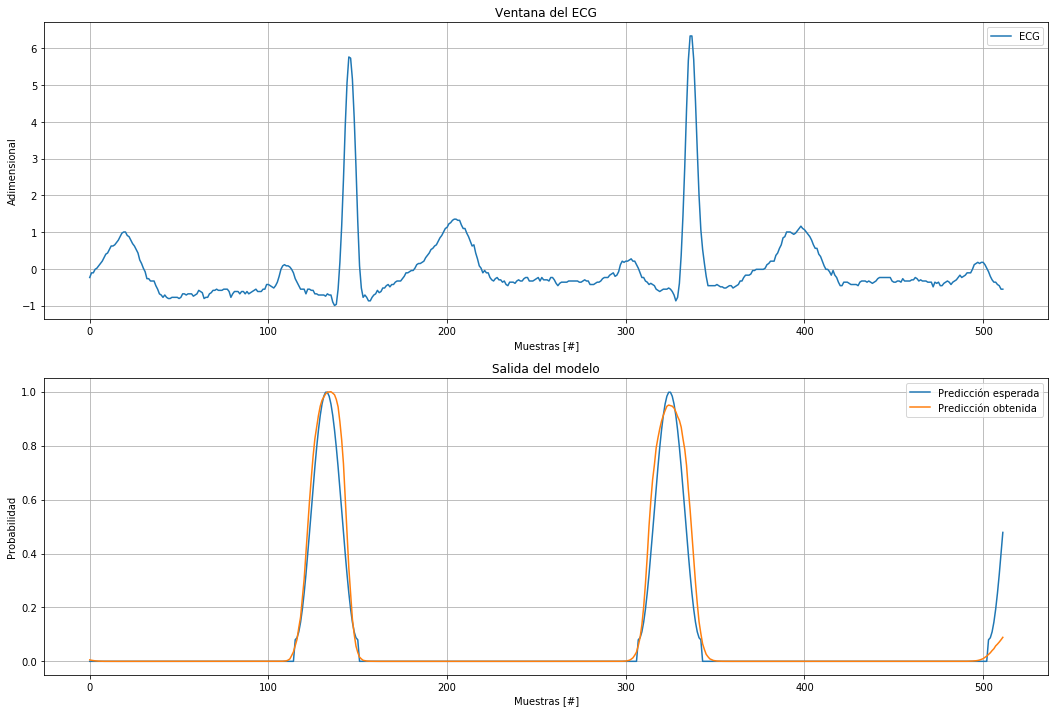

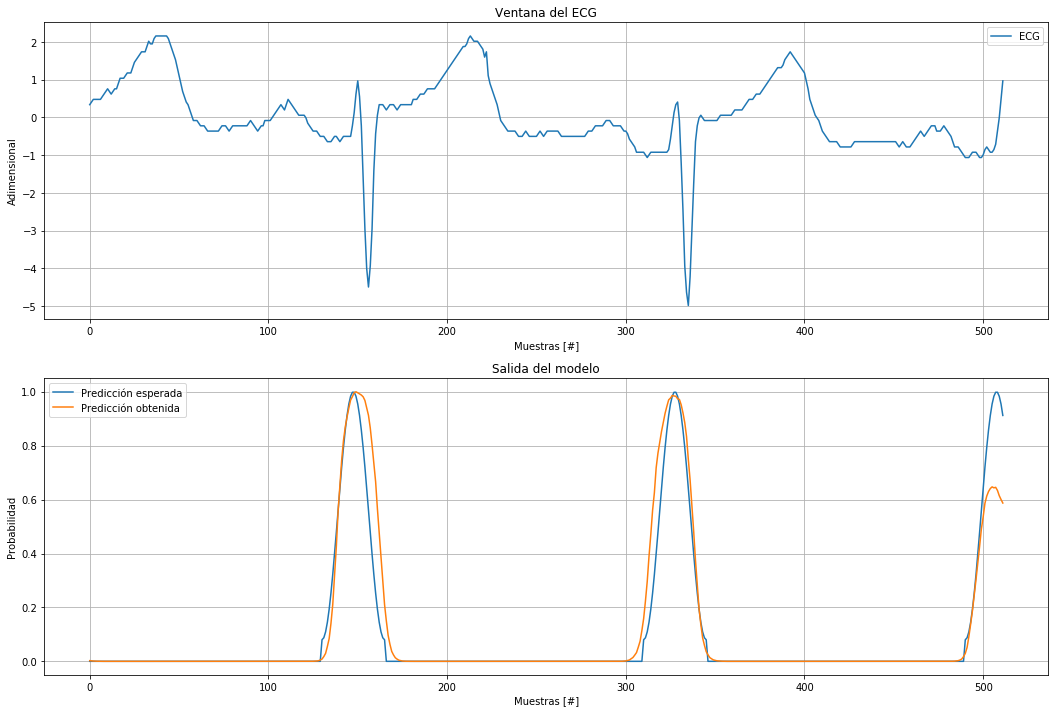

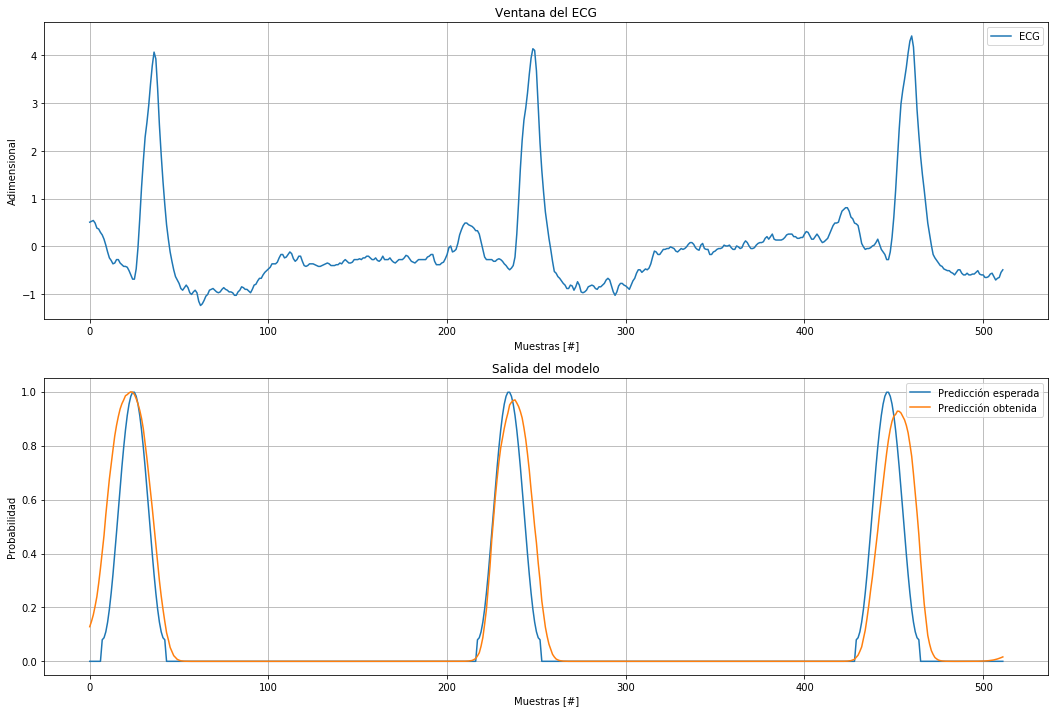

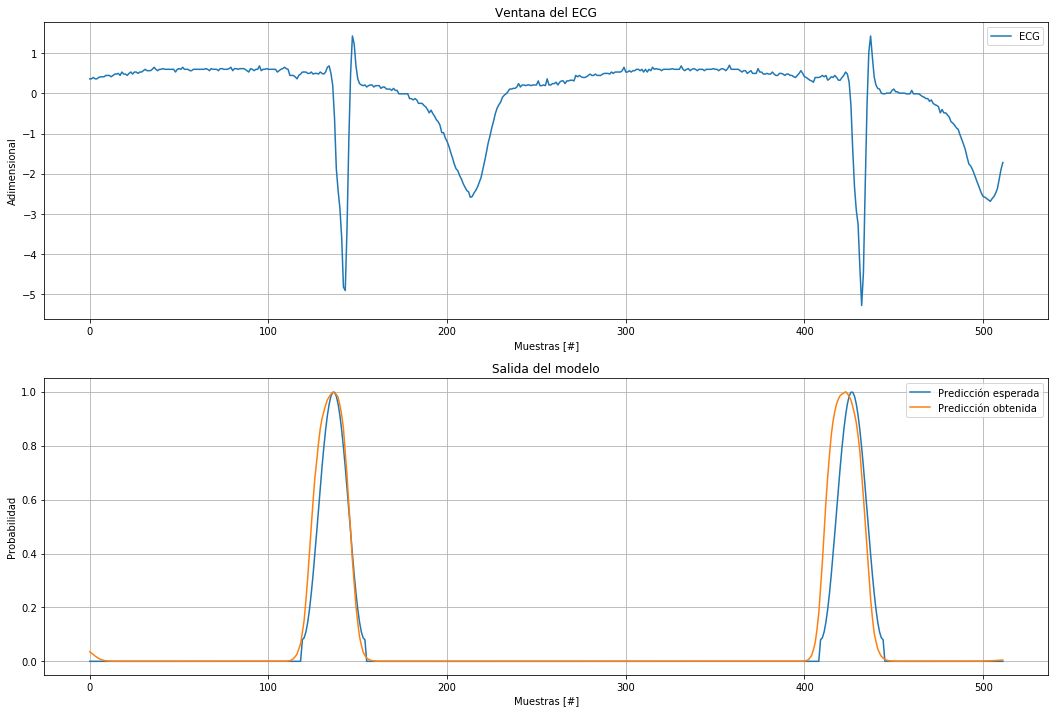

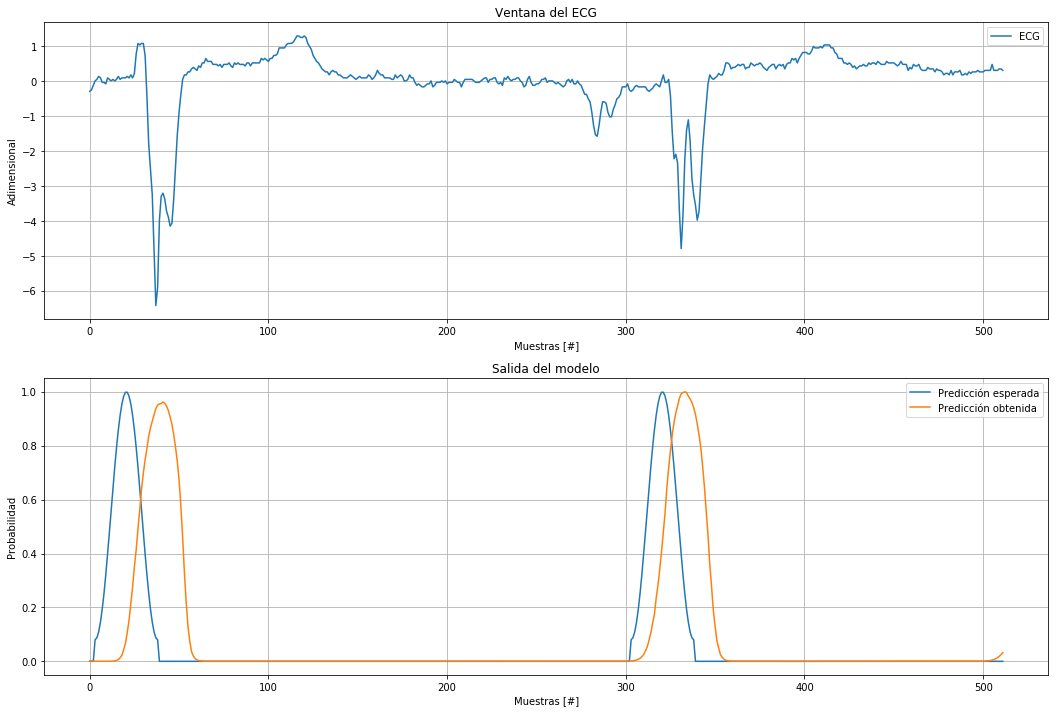

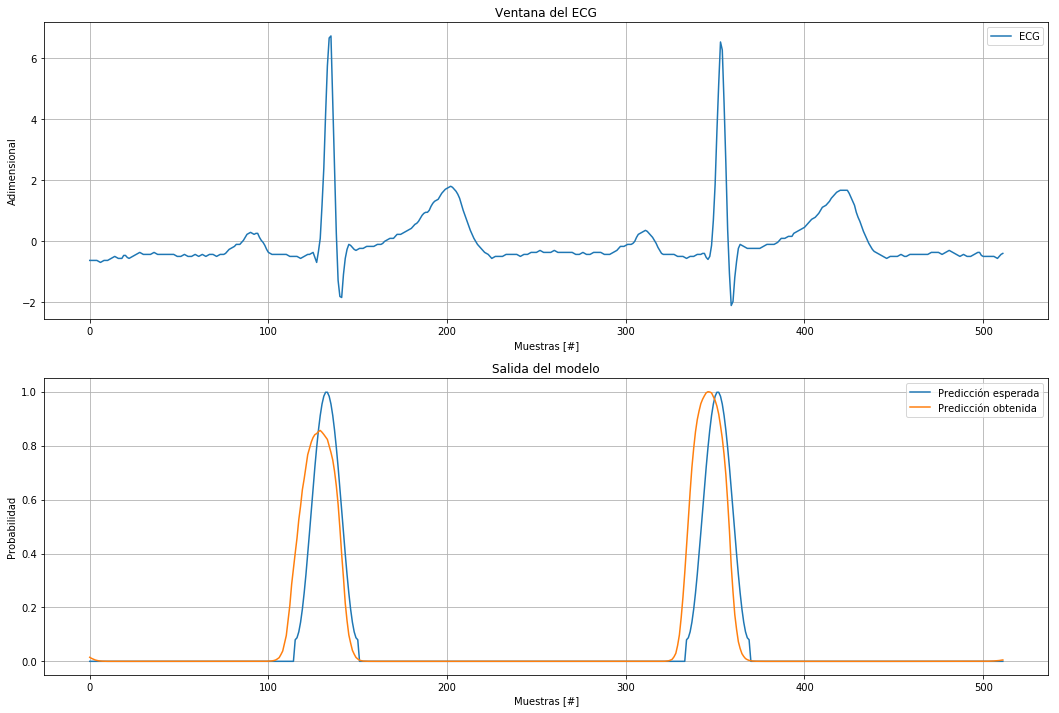

In [10]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod1', predictions)

Se calculan los parametros de performance...

In [11]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_1 = 100*verdadero_p/total
tasa_error_1 = 100*(falso_n + falso_p)/total
sensibilidad_1 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_1 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

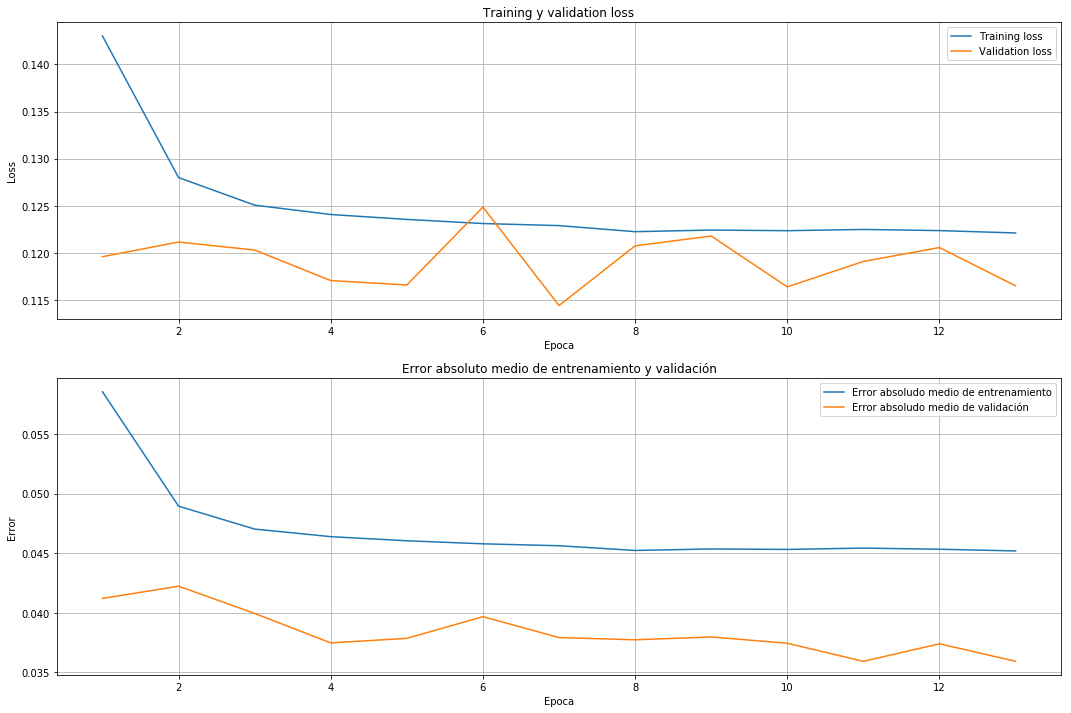

In [12]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

***
### Modelo 2

##### Arquitectura

In [13]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_10 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_10 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_11 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_11 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 254, 16)           0         
__________

##### Configuración de red

In [14]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'binary_crossentropy',     
              metrics = ['mae', 'mse', 'accuracy']) 

##### Entrenamiento

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model2.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 425s 2ms/step - loss: 0.1433 - mean_absolute_error: 0.0586 - mean_squared_error: 0.0206 - acc: 0.8238 - val_loss: 0.1228 - val_mean_absolute_error: 0.0456 - val_mean_squared_error: 0.0159 - val_acc: 0.8362
Epoch 2/1000
203464/203464 [==============================] - 422s 2ms/step - loss: 0.1290 - mean_absolute_error: 0.0495 - mean_squared_error: 0.0162 - acc: 0.8246 - val_loss: 0.1168 - val_mean_absolute_error: 0.0427 - val_mean_squared_error: 0.0145 - val_acc: 0.8368
Epoch 3/1000
203464/203464 [==============================] - 425s 2ms/step - loss: 0.1261 - mean_absolute_error: 0.0476 - mean_squared_error: 0.0153 - acc: 0.8247 - val_loss: 0.1179 - val_mean_absolute_error: 0.0404 - val_mean_squared_error: 0.0136 - val_acc: 0.8373
Epoch 4/1000
203464/203464 [==============================] - 426s 2ms/step - loss: 0.1248 - mean_absolute_error: 0.0469 - mean_squared_error: 0.

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

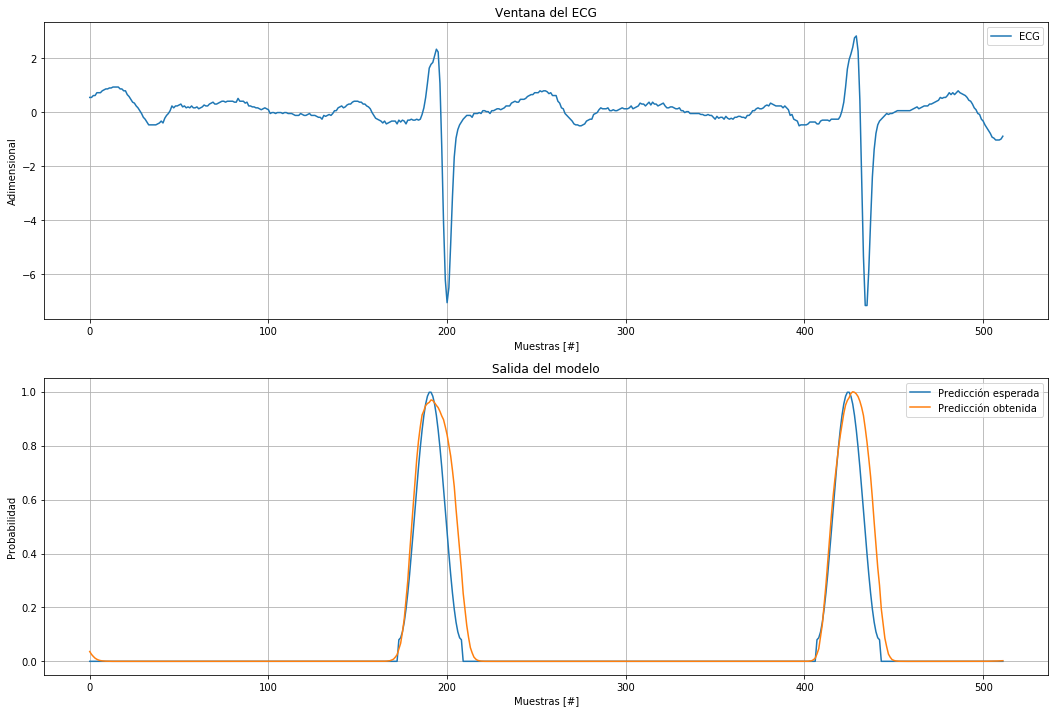

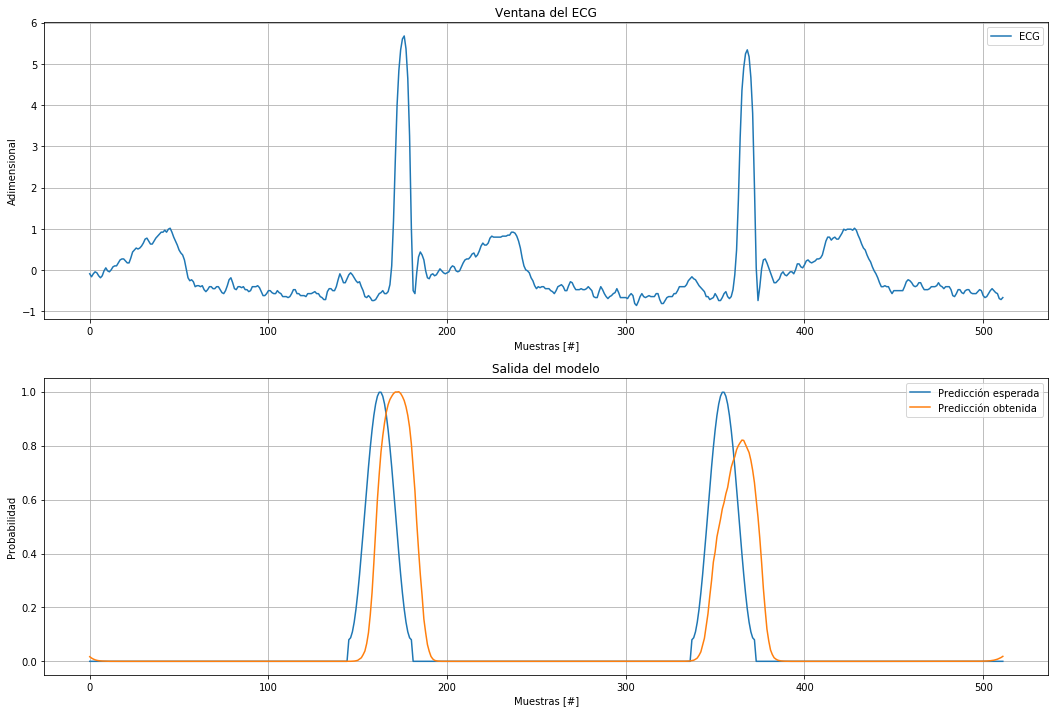

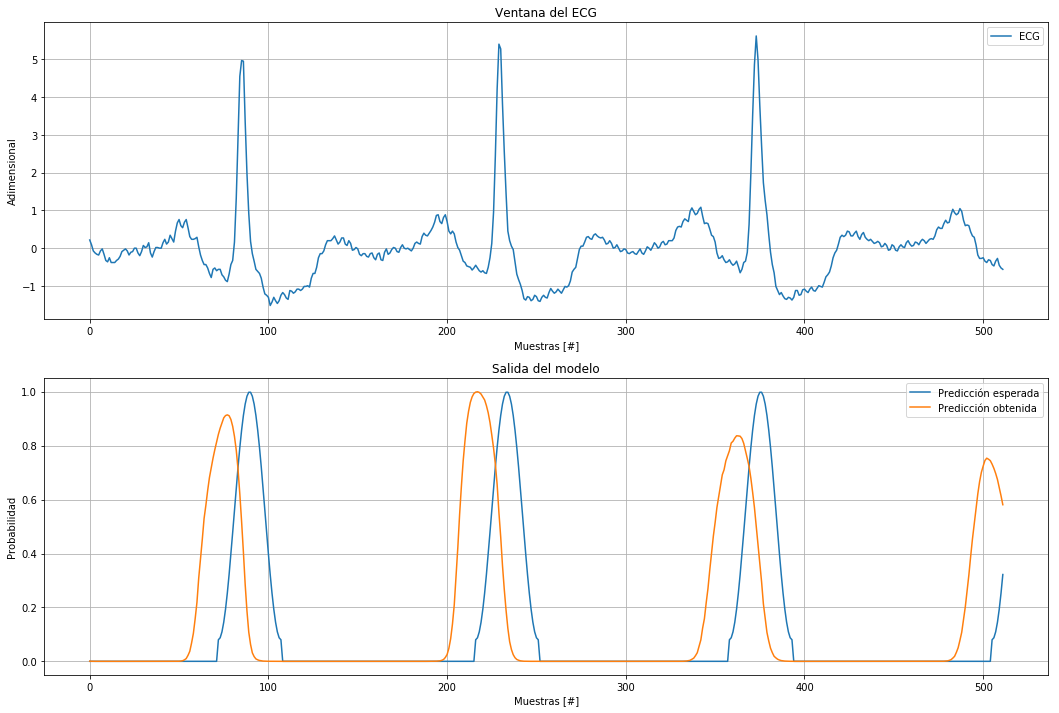

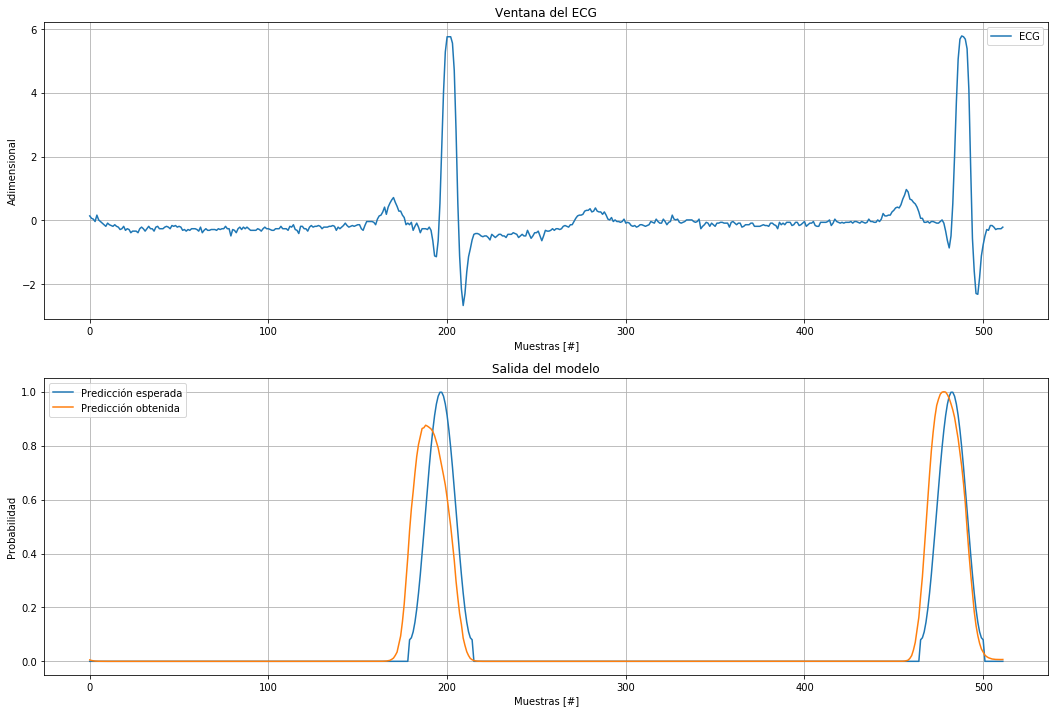

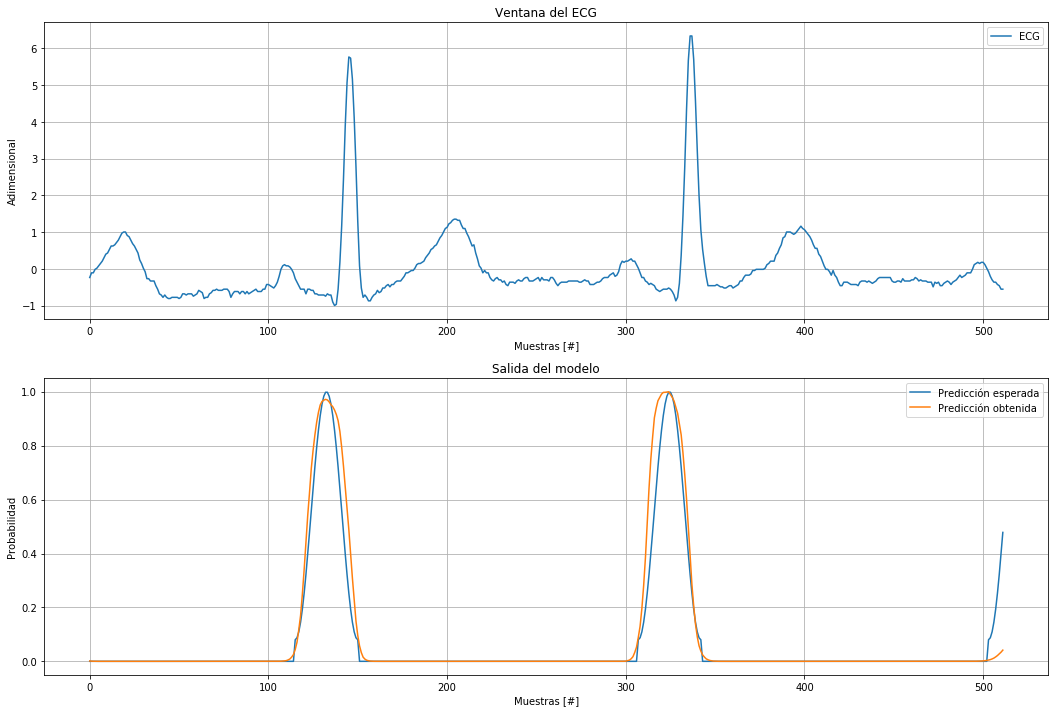

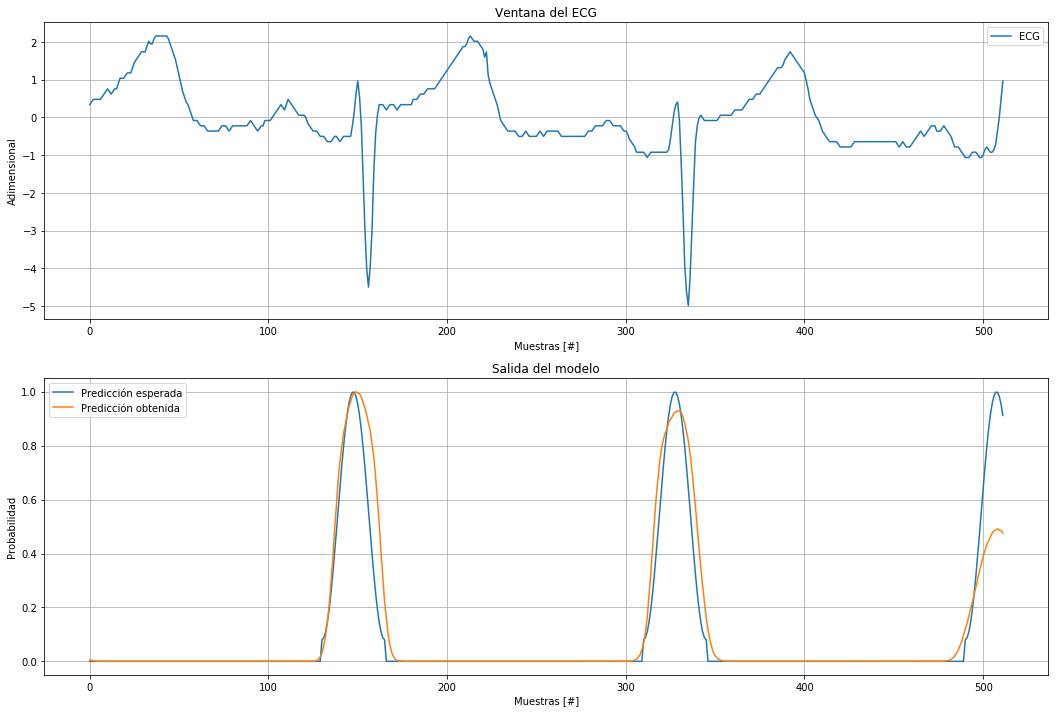

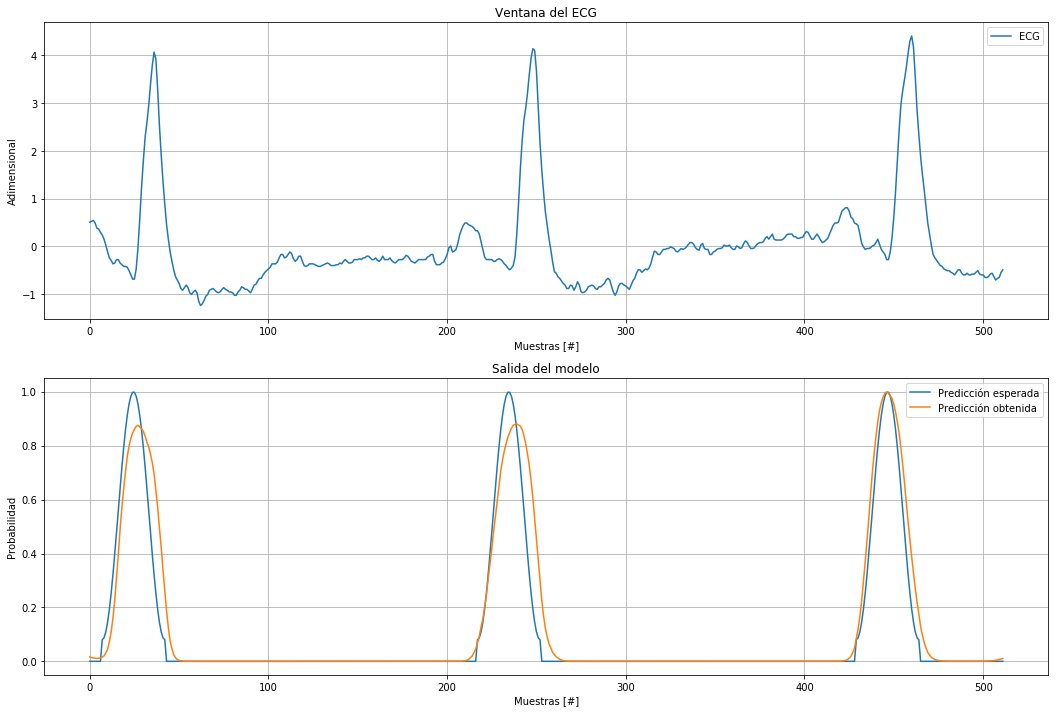

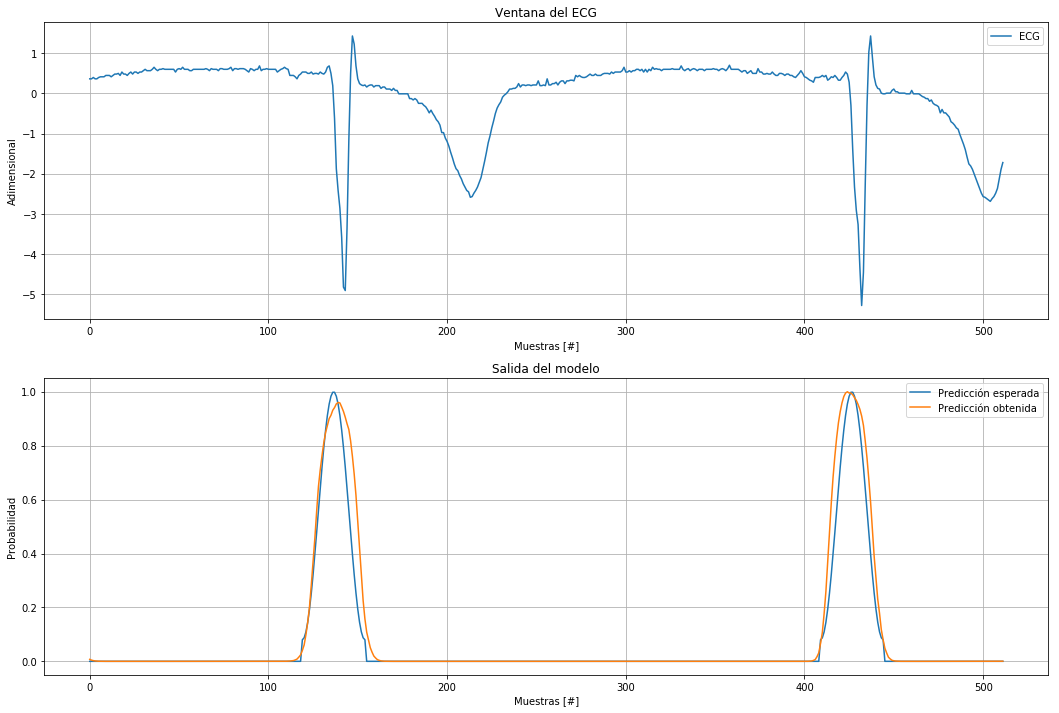

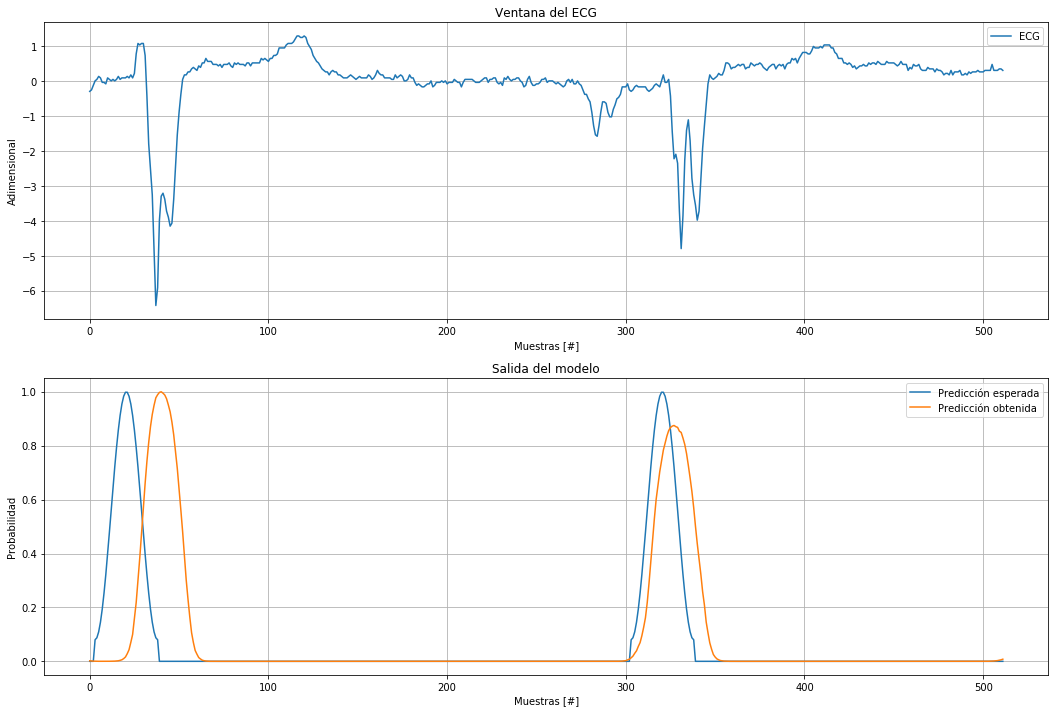

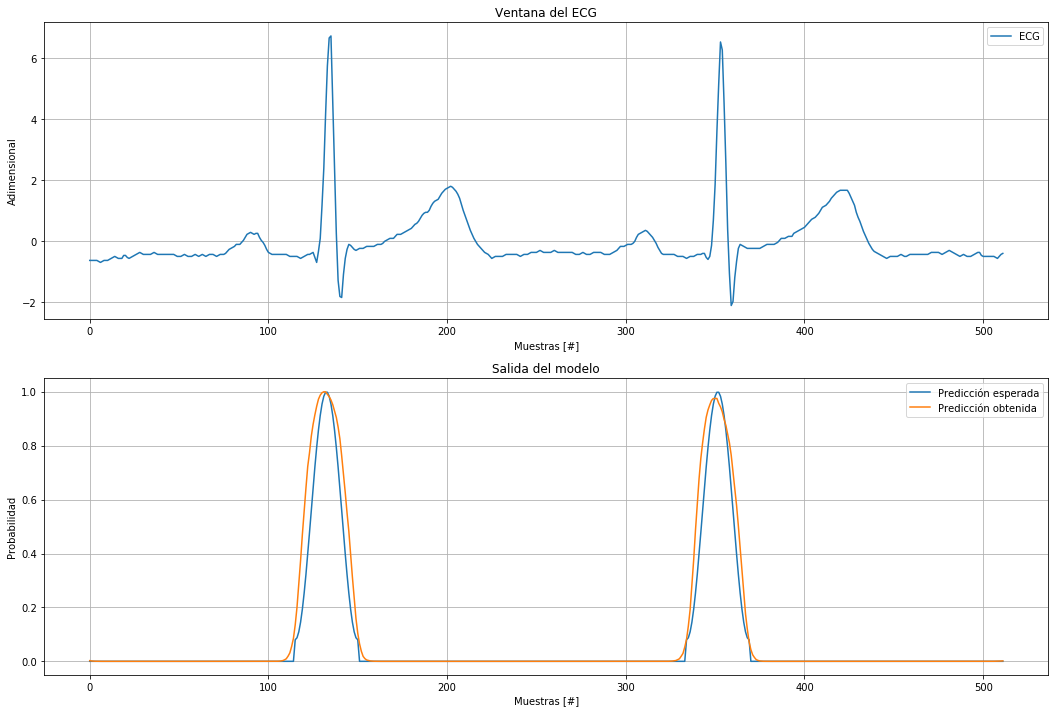

In [17]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod2', predictions)

In [18]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_2 = 100*verdadero_p/total
tasa_error_2 = 100*(falso_n + falso_p)/total
sensibilidad_2 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_2 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

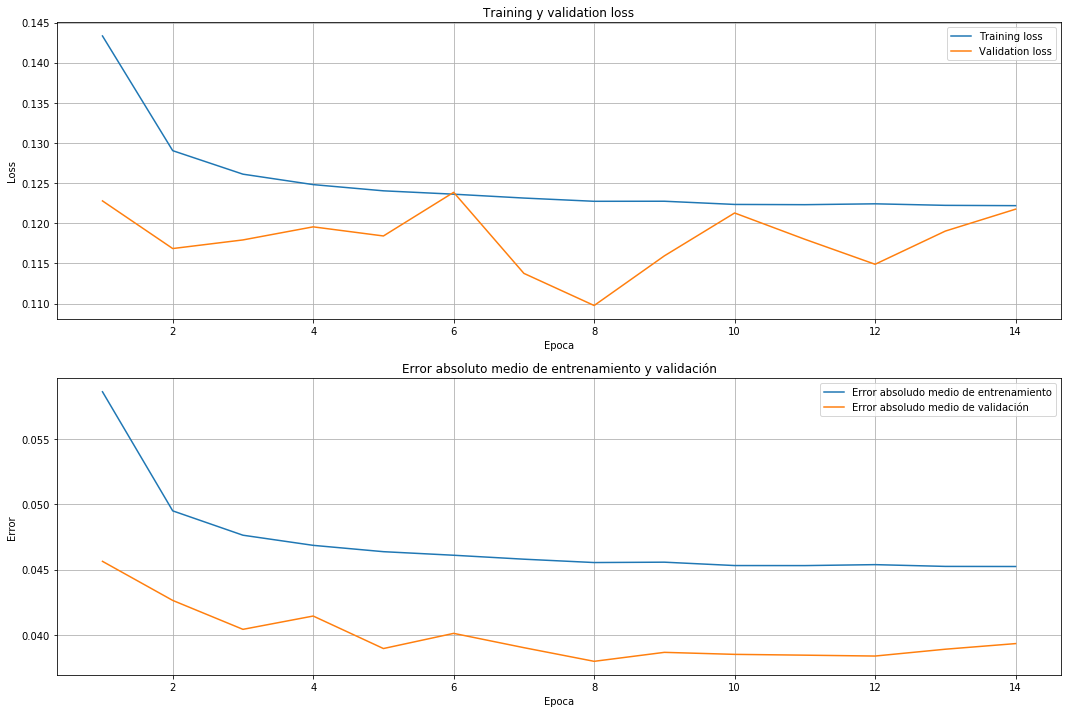

In [19]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

***
### Modelo 3

##### Arquitectura

In [20]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_20 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_20 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_21 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_21 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 254, 16)           0         
__________

##### Configuración de red

In [21]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'mean_squared_error',       # mean squared error
              metrics = ['mae', 'mse', 'accuracy'])  # mean absolute error

##### Entrenamiento

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model3.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 439s 2ms/step - loss: 0.0206 - mean_absolute_error: 0.0599 - mean_squared_error: 0.0206 - acc: 0.0351 - val_loss: 0.0126 - val_mean_absolute_error: 0.0375 - val_mean_squared_error: 0.0126 - val_acc: 0.0347
Epoch 2/1000
203464/203464 [==============================] - 445s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.0480 - mean_squared_error: 0.0157 - acc: 0.0421 - val_loss: 0.0128 - val_mean_absolute_error: 0.0368 - val_mean_squared_error: 0.0128 - val_acc: 0.0303
Epoch 3/1000
203464/203464 [==============================] - 435s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.0456 - mean_squared_error: 0.0148 - acc: 0.0444 - val_loss: 0.0132 - val_mean_absolute_error: 0.0368 - val_mean_squared_error: 0.0132 - val_acc: 0.0341
Epoch 4/1000
203464/203464 [==============================] - 435s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0445 - mean_squared_error: 0.

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

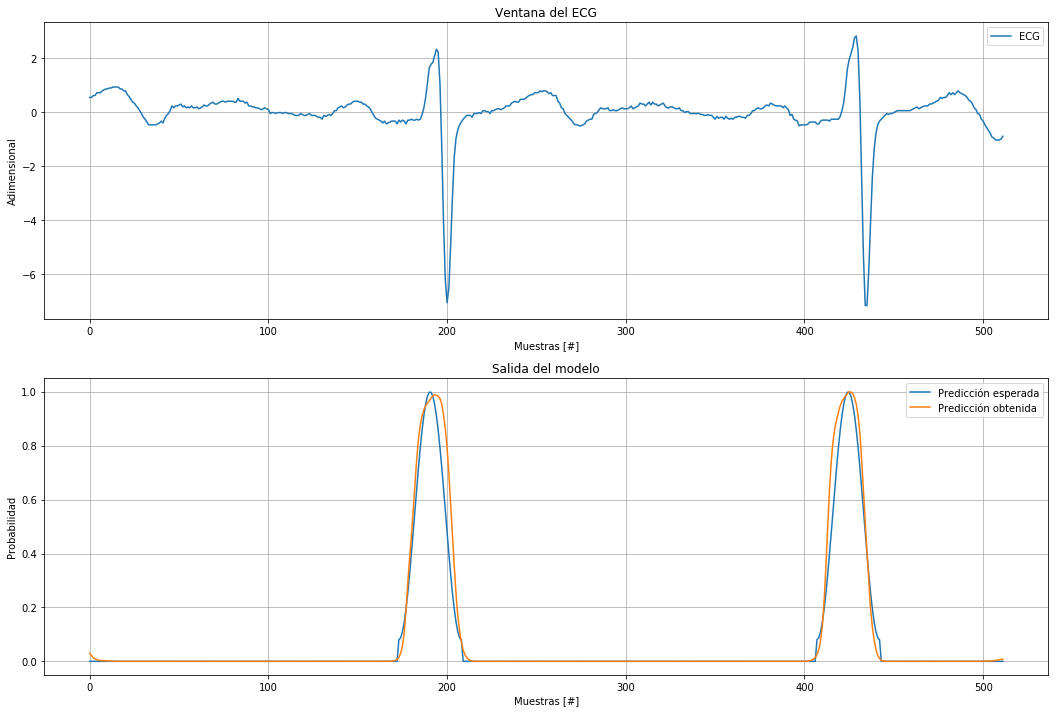

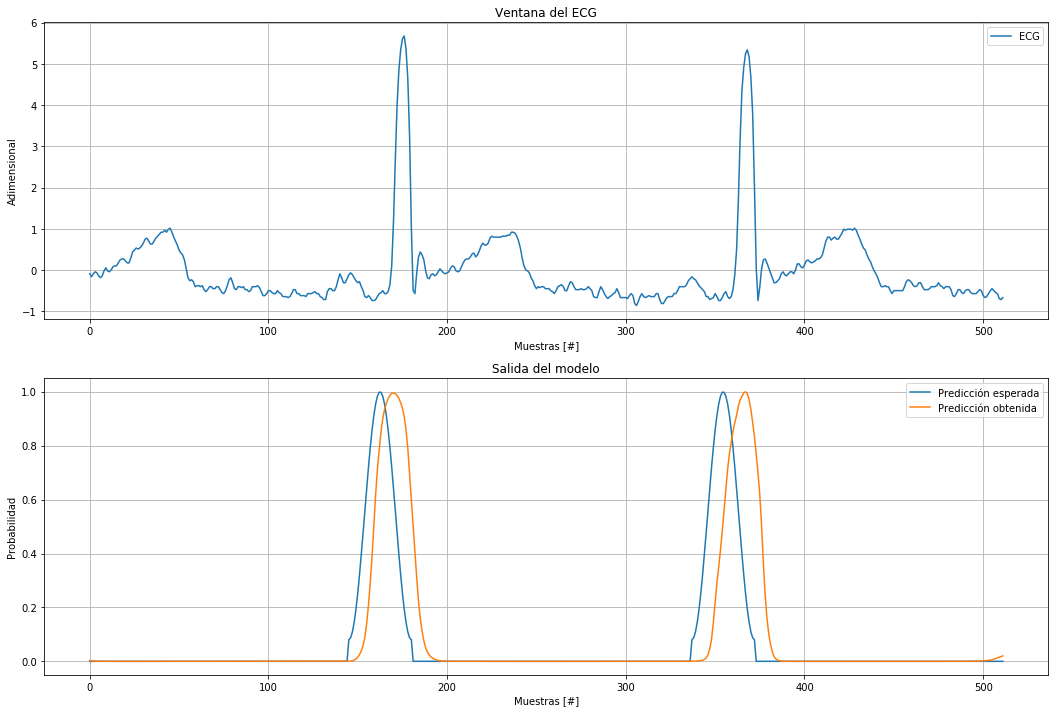

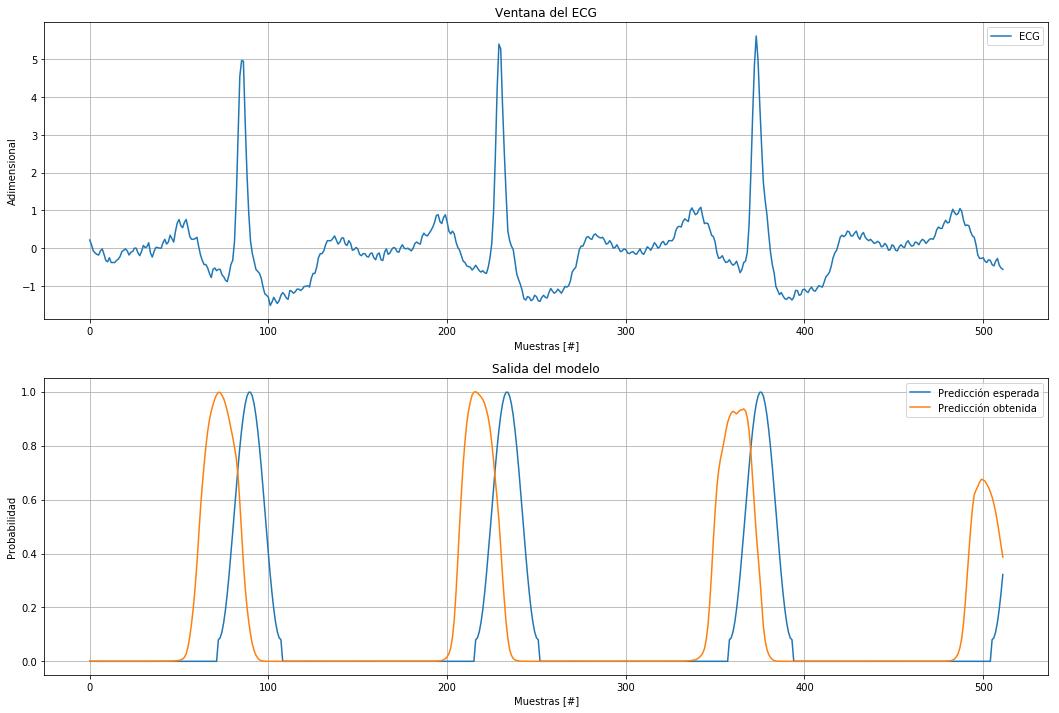

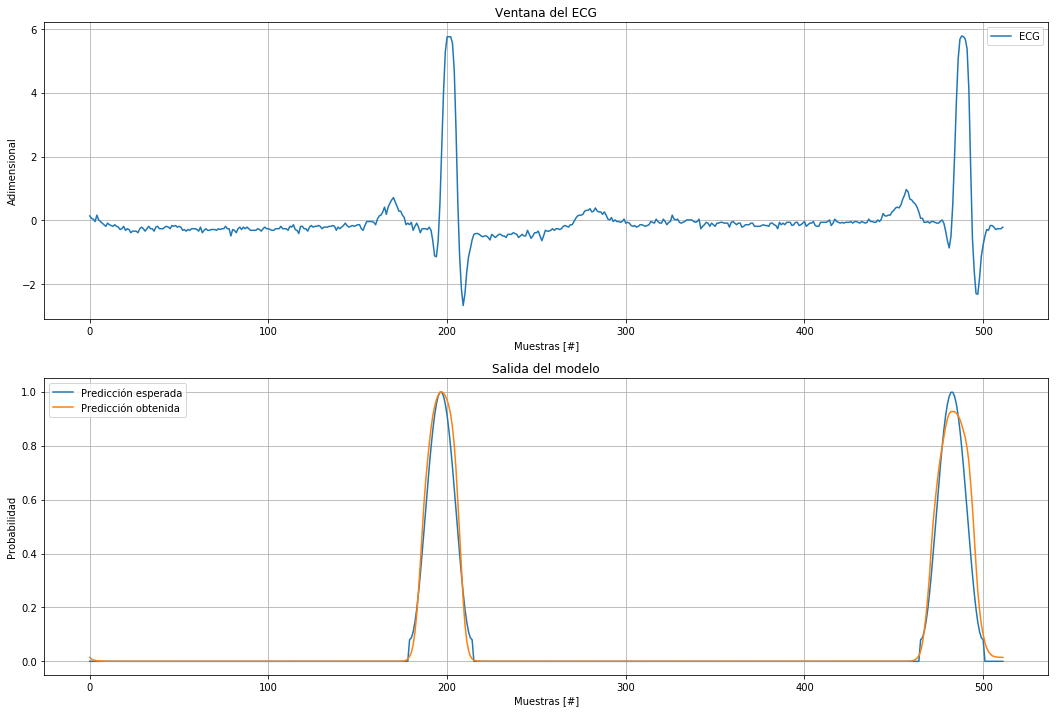

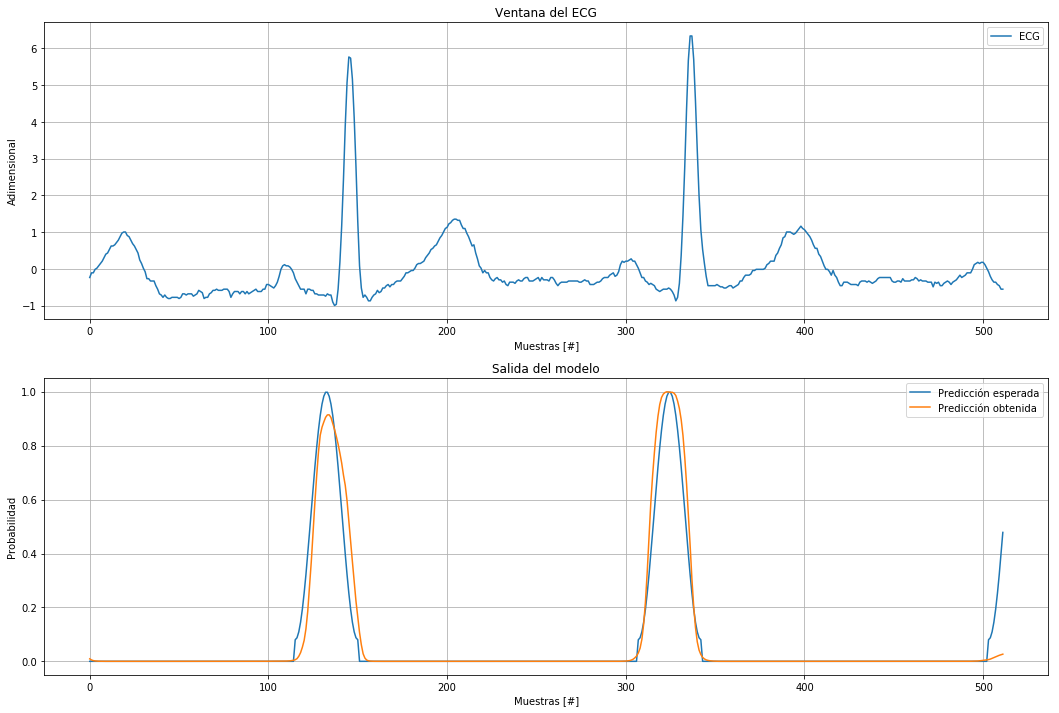

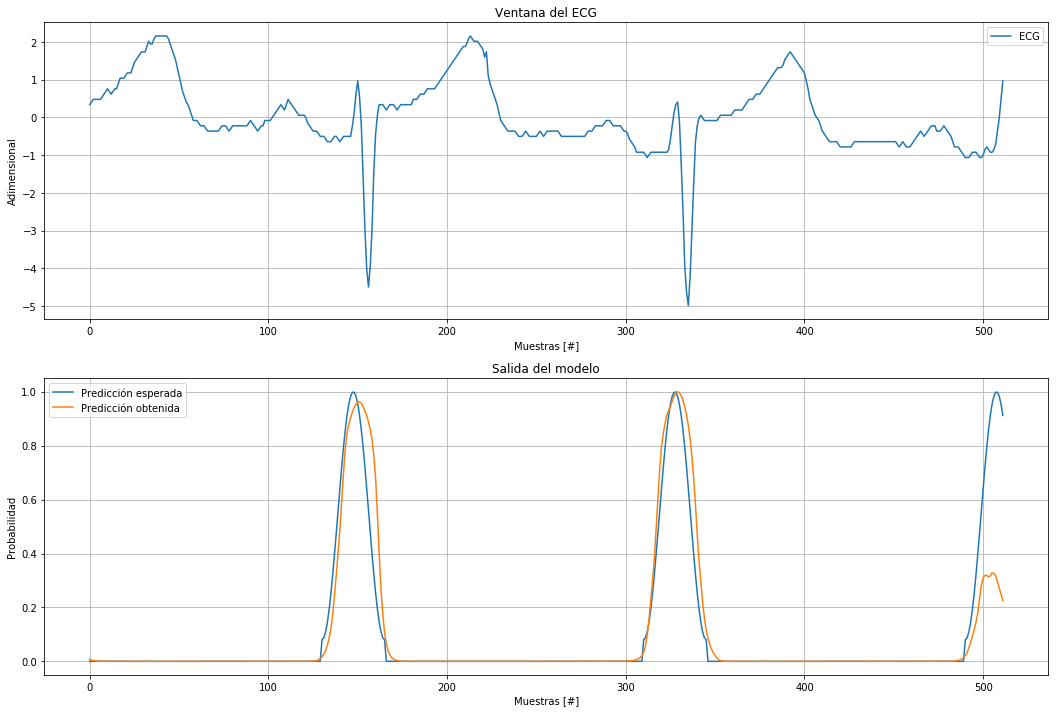

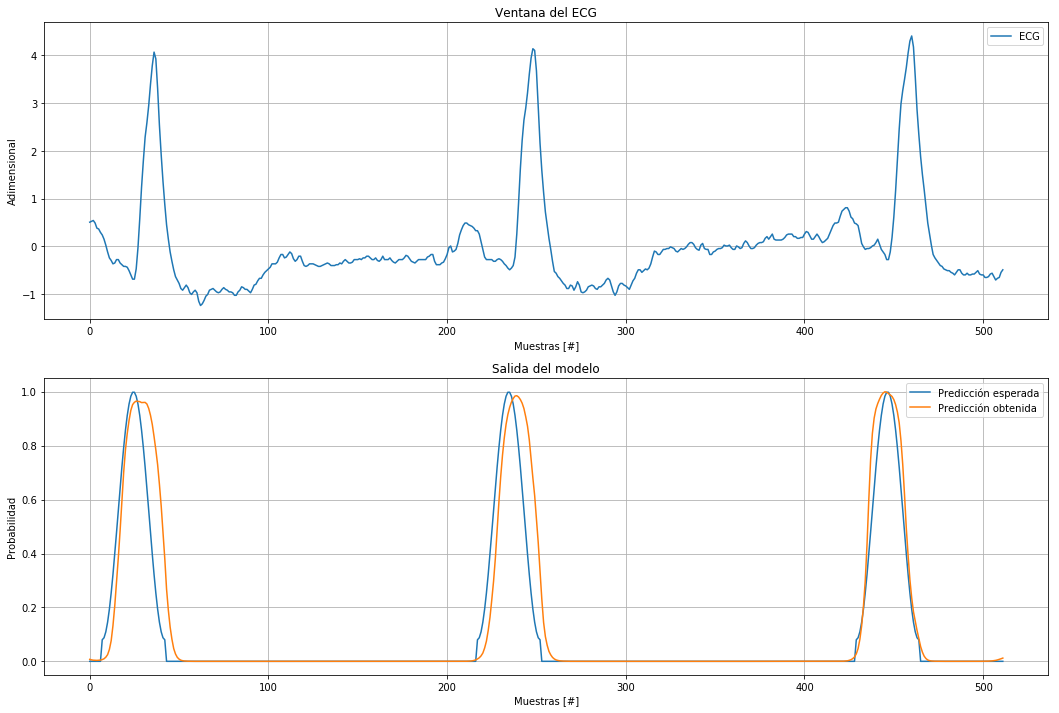

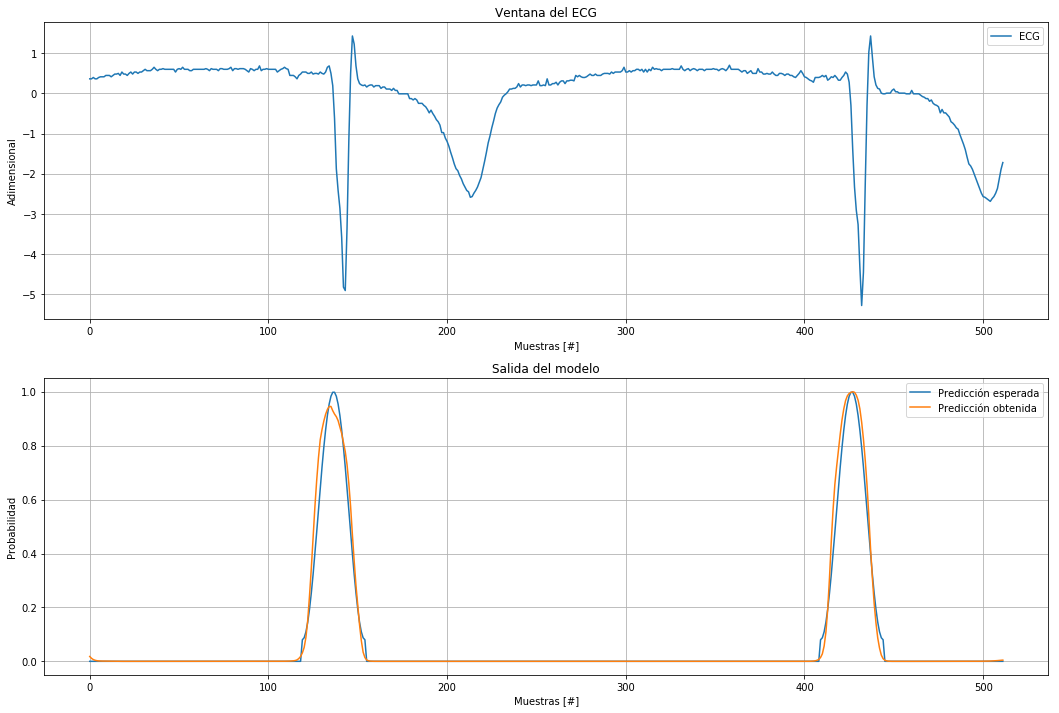

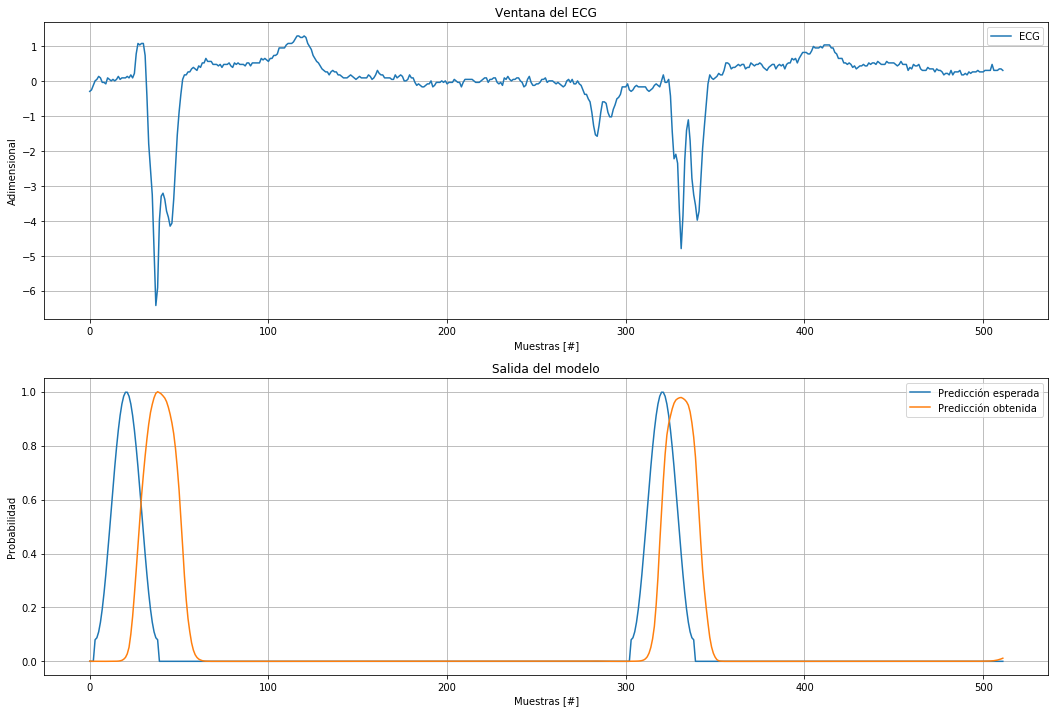

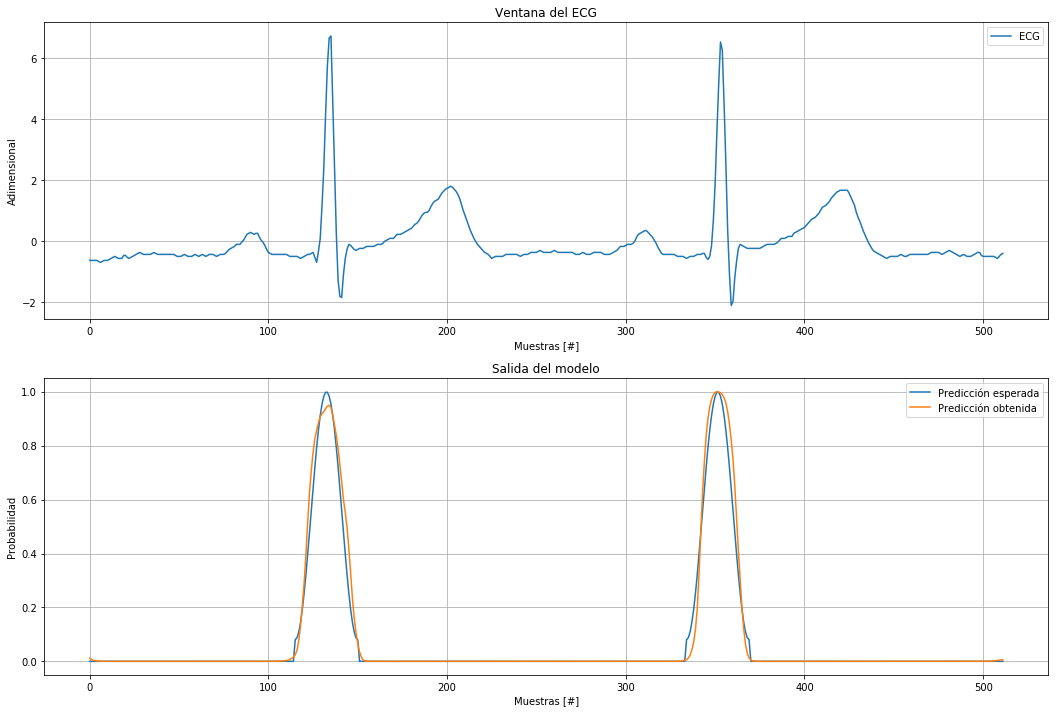

In [24]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()

np.save('data/pred_mod3', predictions)

In [25]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_3 = 100*verdadero_p/total
tasa_error_3 = 100*(falso_n + falso_p)/total
sensibilidad_3 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_3 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

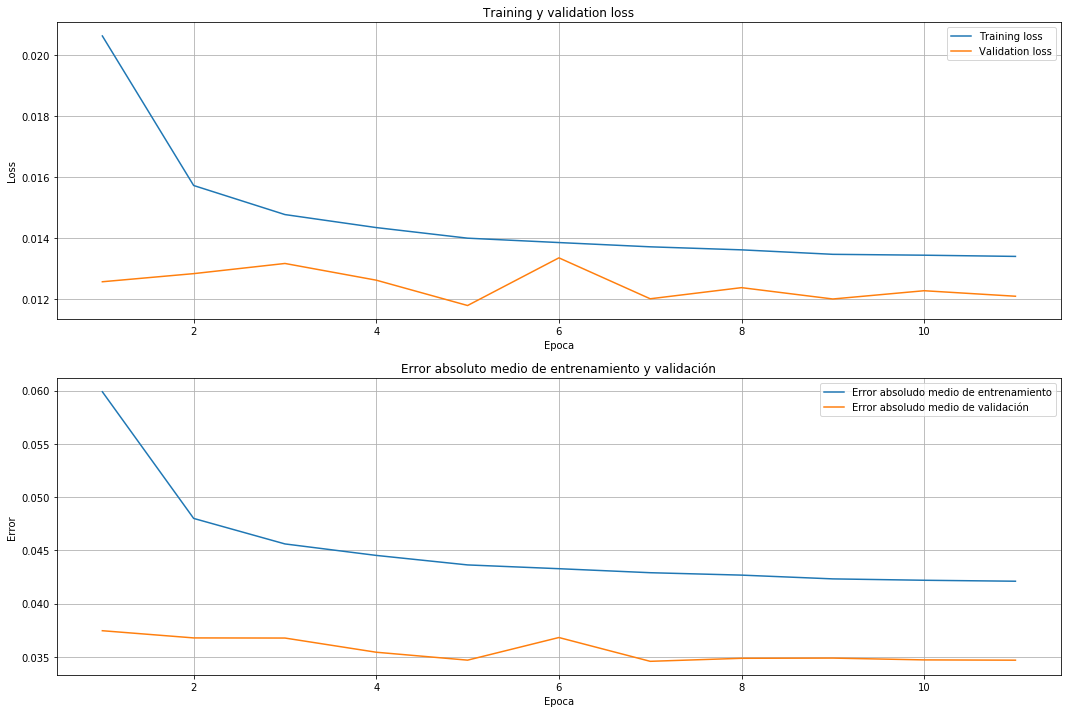

In [26]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

***
### Modelo 4

##### Arquitectura

In [27]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_30 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_30 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_31 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_31 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
average_pooling1d_4 (Average (None, 254, 16)           0         
__________

##### Configuración de red

In [28]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'mean_squared_error',       # mean squared error
              metrics = ['mae', 'mse', 'accuracy'])  # mean absolute error

##### Entrenamiento

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model4.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 429s 2ms/step - loss: 0.0210 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0210 - acc: 0.0357 - val_loss: 0.0139 - val_mean_absolute_error: 0.0405 - val_mean_squared_error: 0.0139 - val_acc: 0.0319
Epoch 2/1000
203464/203464 [==============================] - 426s 2ms/step - loss: 0.0158 - mean_absolute_error: 0.0482 - mean_squared_error: 0.0158 - acc: 0.0431 - val_loss: 0.0122 - val_mean_absolute_error: 0.0361 - val_mean_squared_error: 0.0122 - val_acc: 0.0376
Epoch 3/1000
203464/203464 [==============================] - 430s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0459 - mean_squared_error: 0.0149 - acc: 0.0451 - val_loss: 0.0127 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0127 - val_acc: 0.0362
Epoch 4/1000
203464/203464 [==============================] - 444s 2ms/step - loss: 0.0145 - mean_absolute_error: 0.0448 - mean_squared_error: 0.

203464/203464 [==============================] - 426s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0132 - acc: 0.0510 - val_loss: 0.0130 - val_mean_absolute_error: 0.0358 - val_mean_squared_error: 0.0130 - val_acc: 0.0396


##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

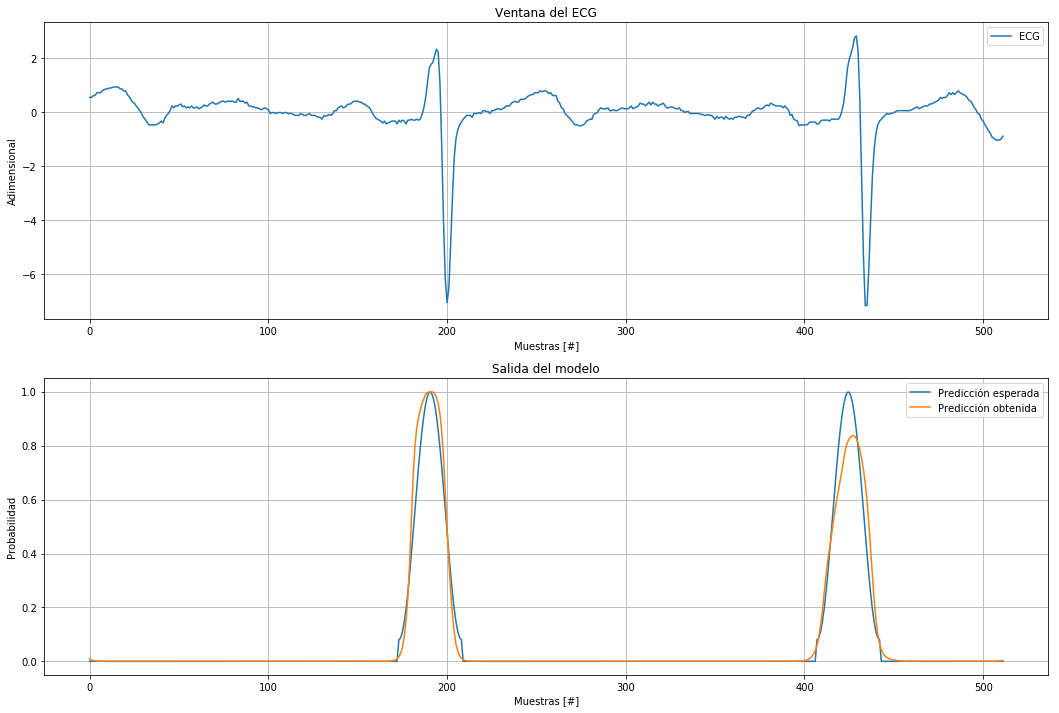

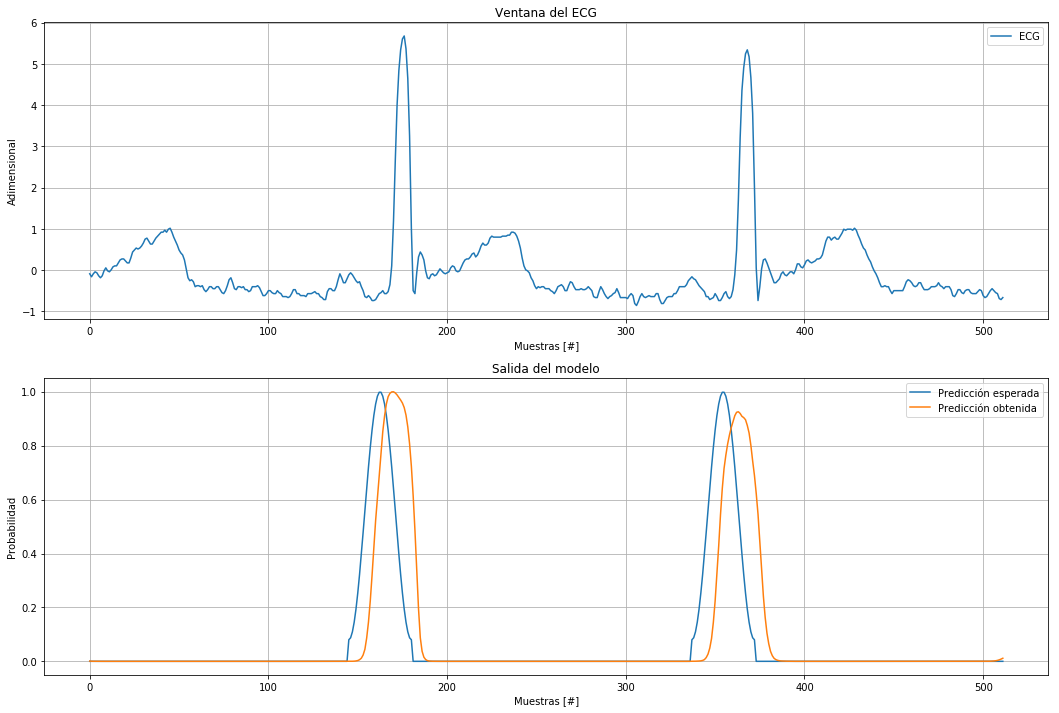

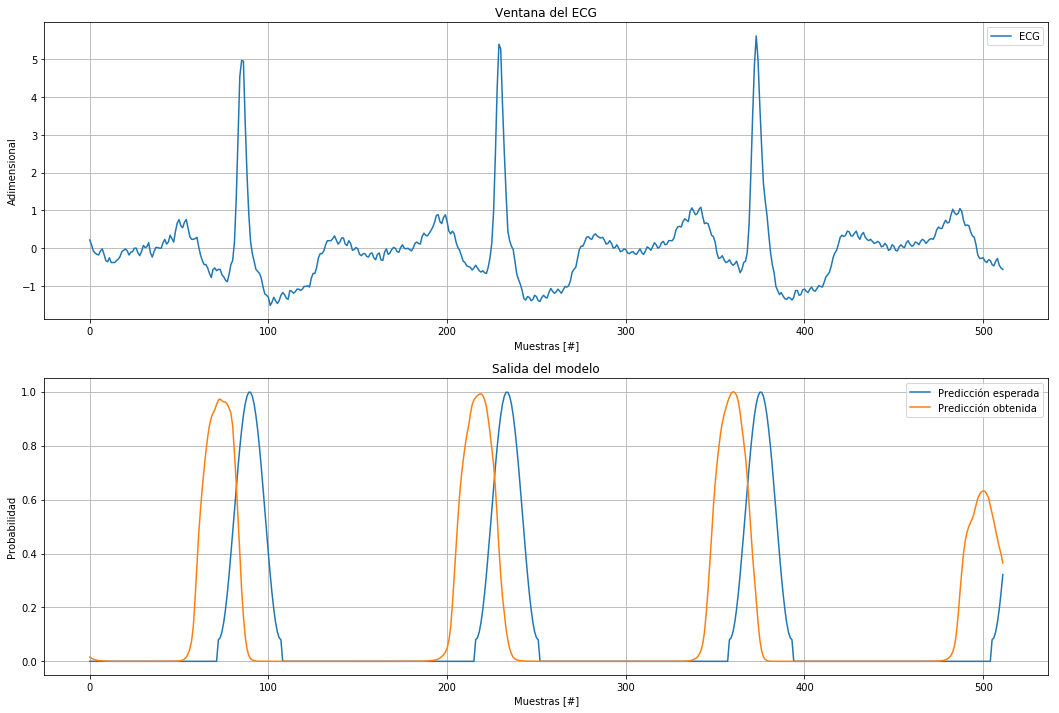

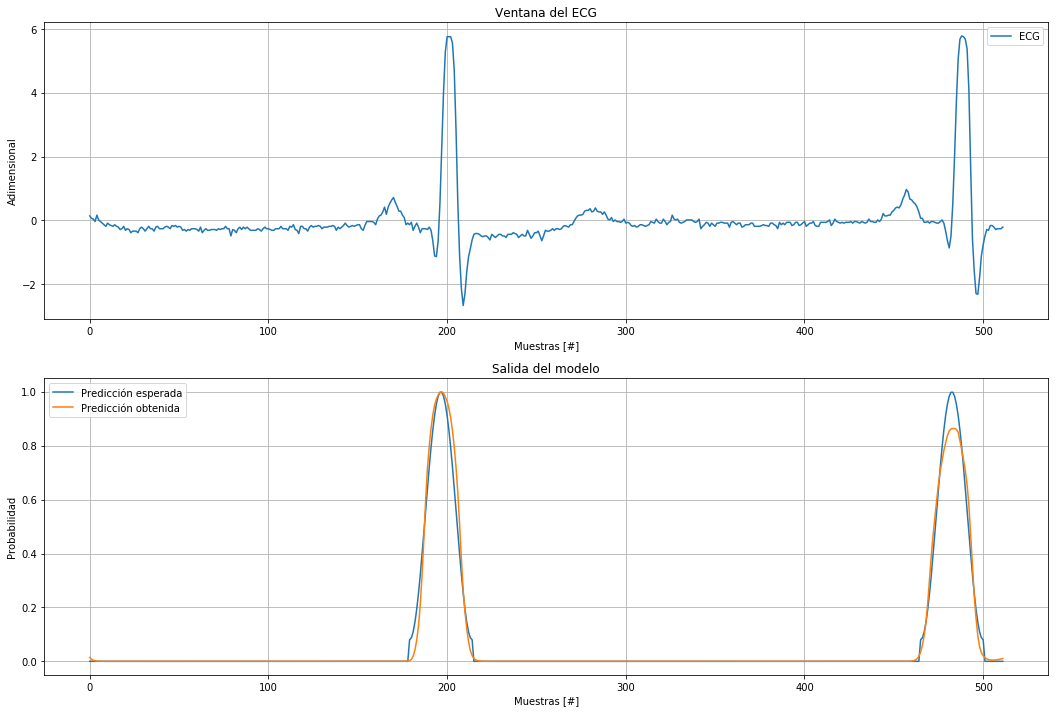

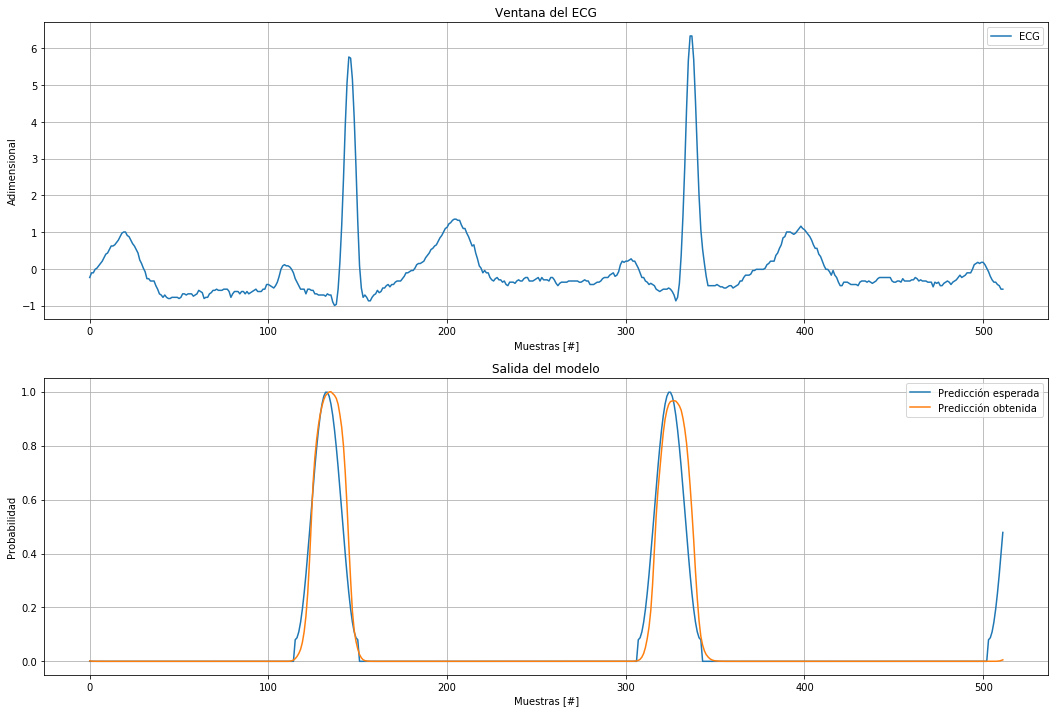

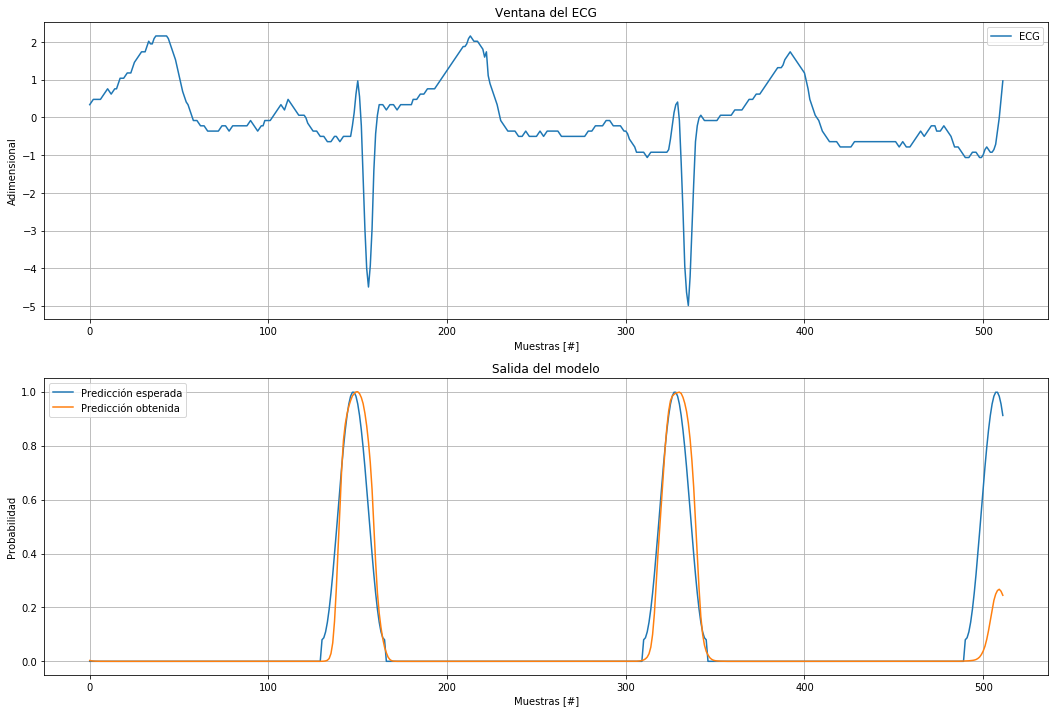

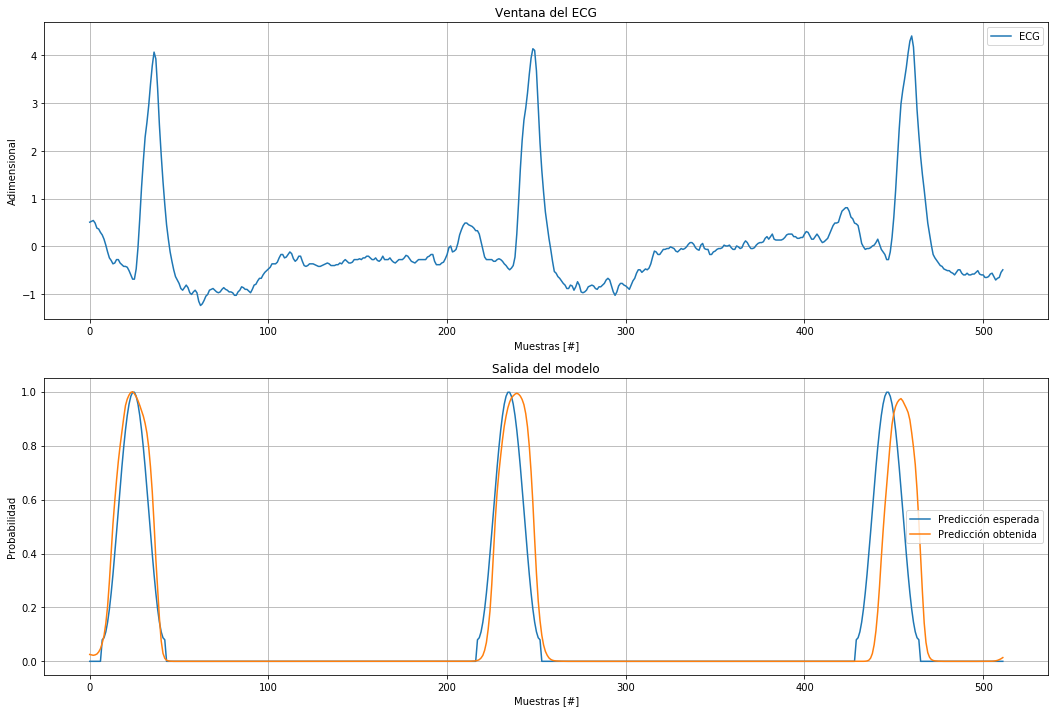

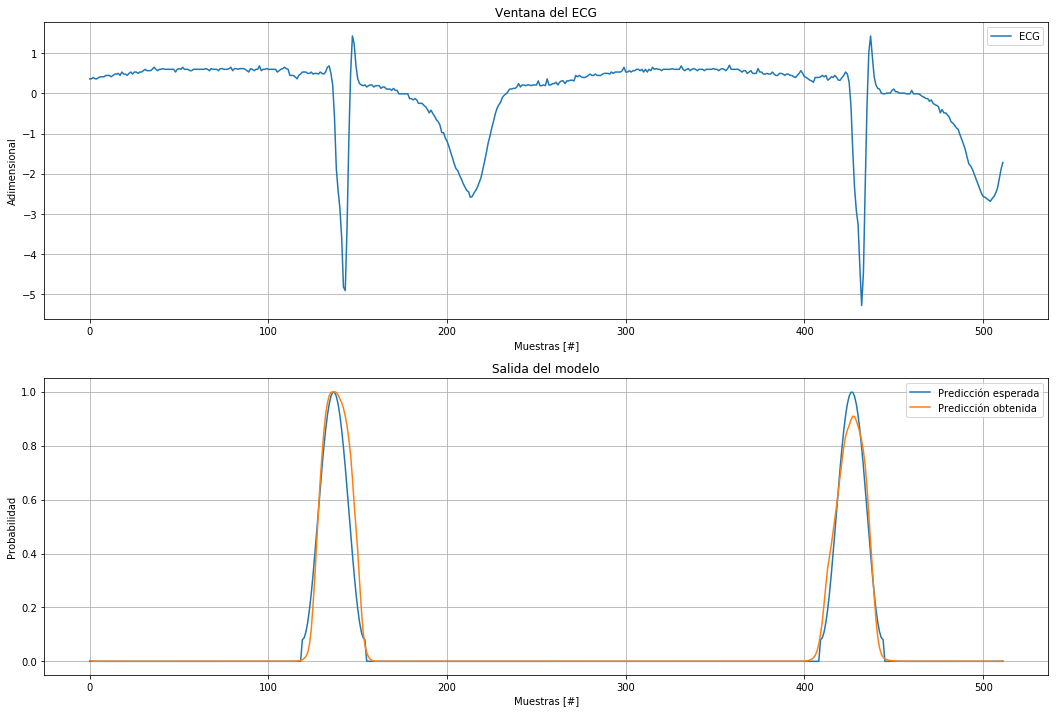

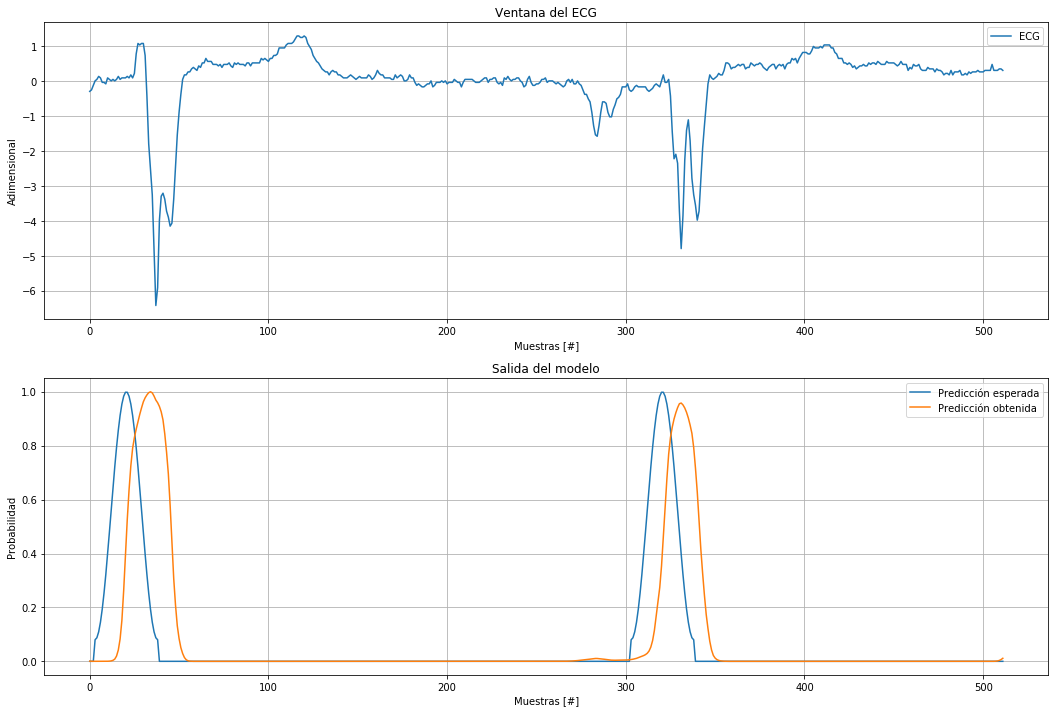

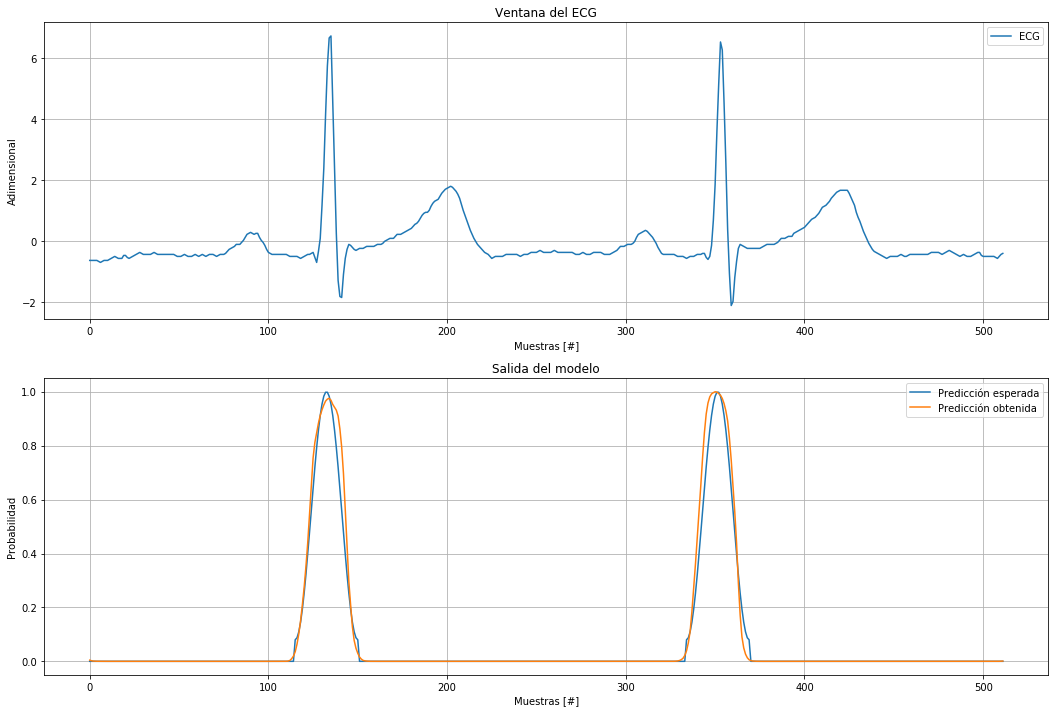

In [31]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod4', predictions)

In [32]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_4 = 100*verdadero_p/total
tasa_error_4 = 100*(falso_n + falso_p)/total
sensibilidad_4 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_4 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

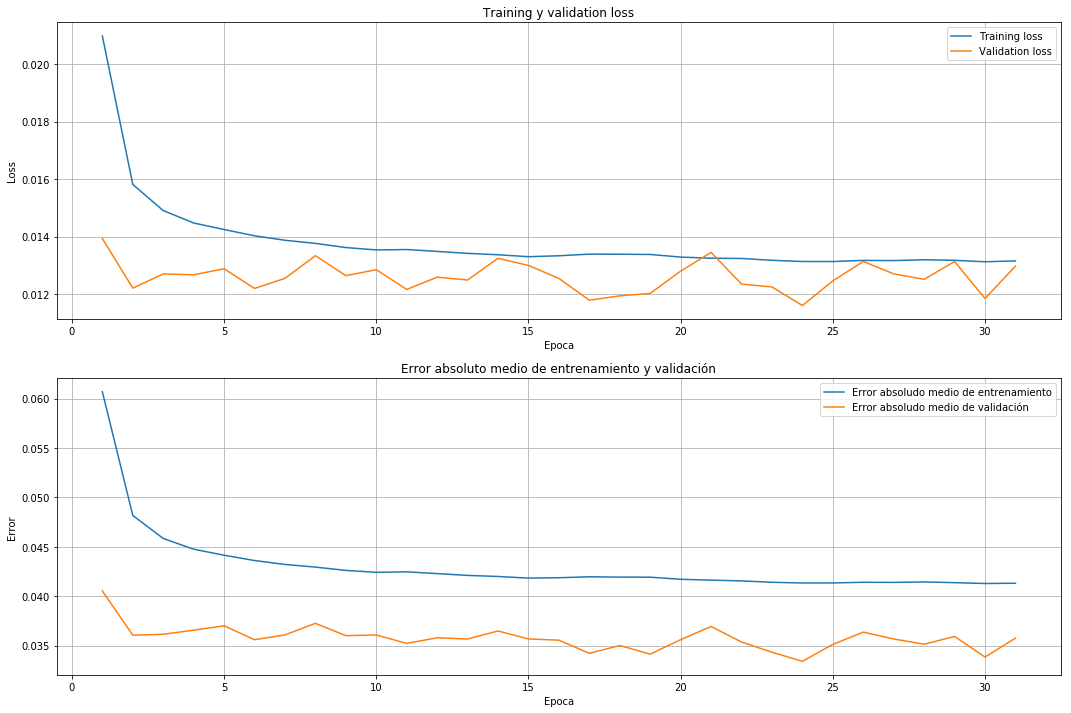

In [33]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

***
### Modelo 5

##### Arquitectura

In [34]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_40 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_40 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_41 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_41 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 254, 16)           0         
__________

##### Configuración de red

In [35]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'logcosh',       # mean squared error
              metrics = ['mae', 'mse', 'accuracy'])  # mean absolute error

##### Entrenamiento

In [36]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model5.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 443s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0596 - mean_squared_error: 0.0210 - acc: 0.0360 - val_loss: 0.0065 - val_mean_absolute_error: 0.0391 - val_mean_squared_error: 0.0137 - val_acc: 0.0415
Epoch 2/1000
203464/203464 [==============================] - 443s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0480 - mean_squared_error: 0.0160 - acc: 0.0433 - val_loss: 0.0060 - val_mean_absolute_error: 0.0363 - val_mean_squared_error: 0.0125 - val_acc: 0.0411
Epoch 3/1000
203464/203464 [==============================] - 440s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0456 - mean_squared_error: 0.0150 - acc: 0.0458 - val_loss: 0.0061 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0127 - val_acc: 0.0359
Epoch 4/1000
203464/203464 [==============================] - 438s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0445 - mean_squared_error: 0.

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

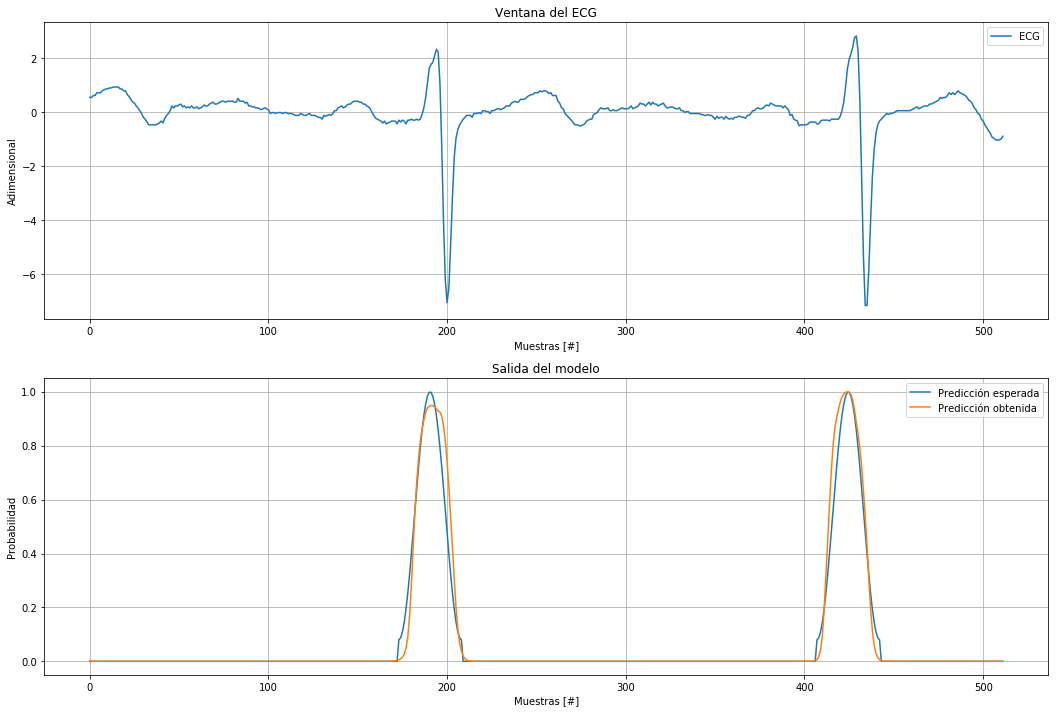

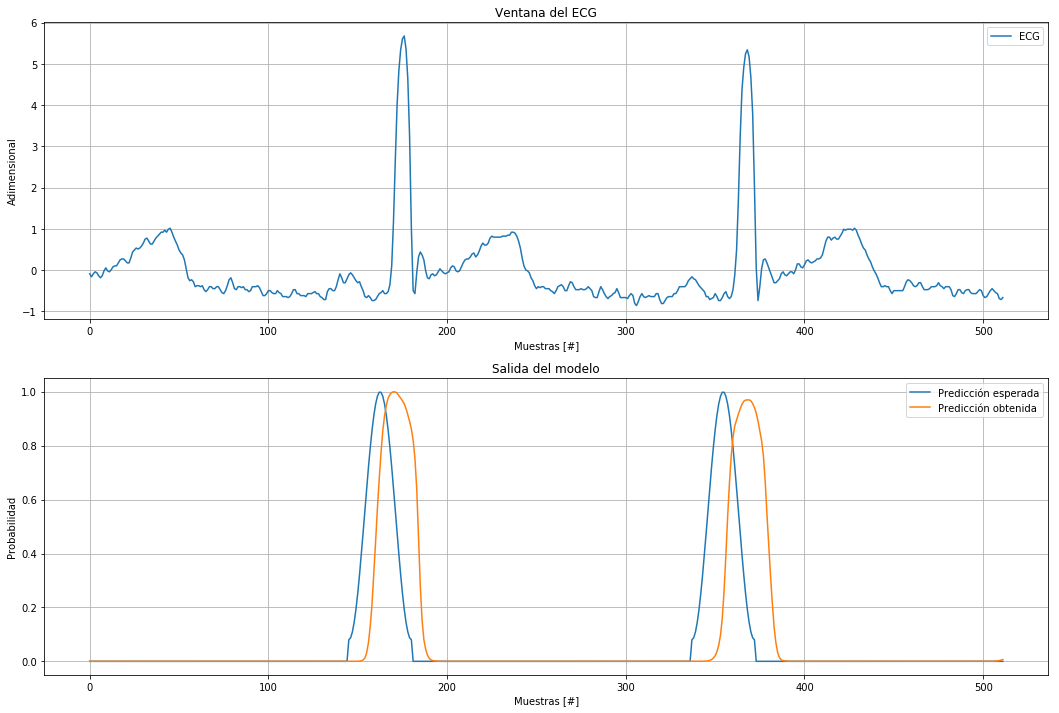

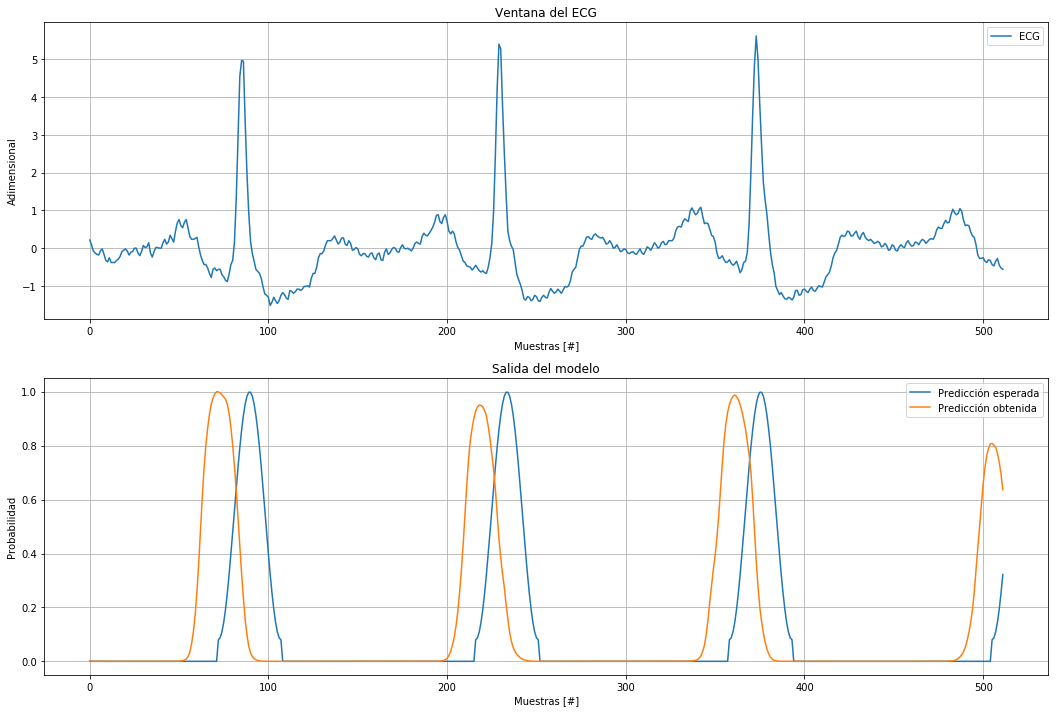

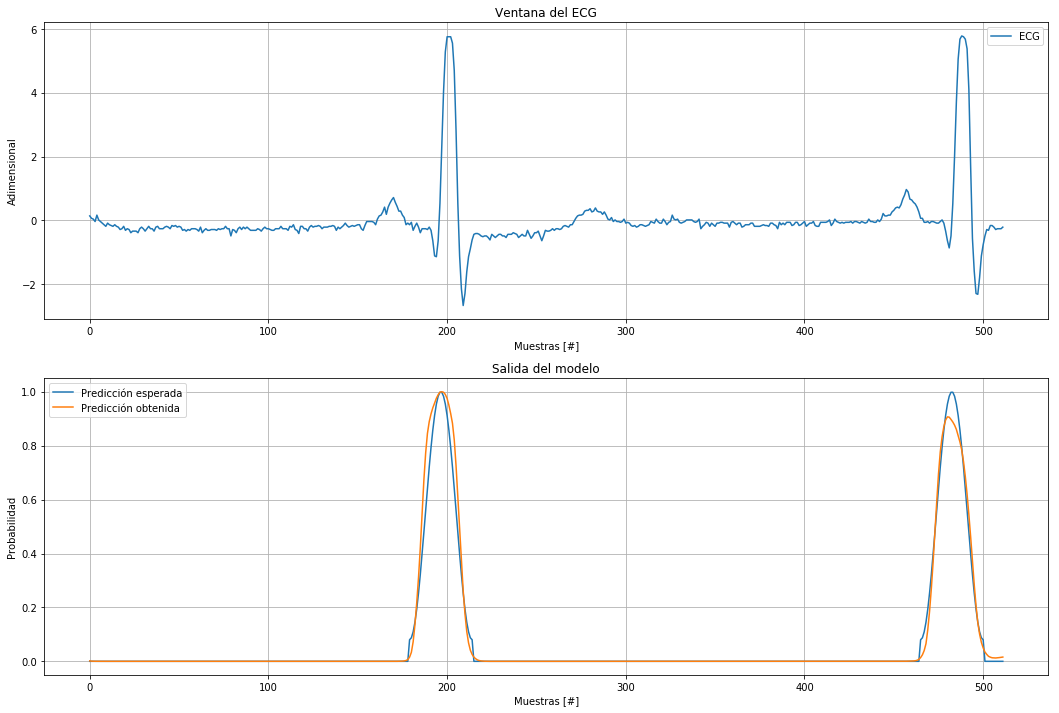

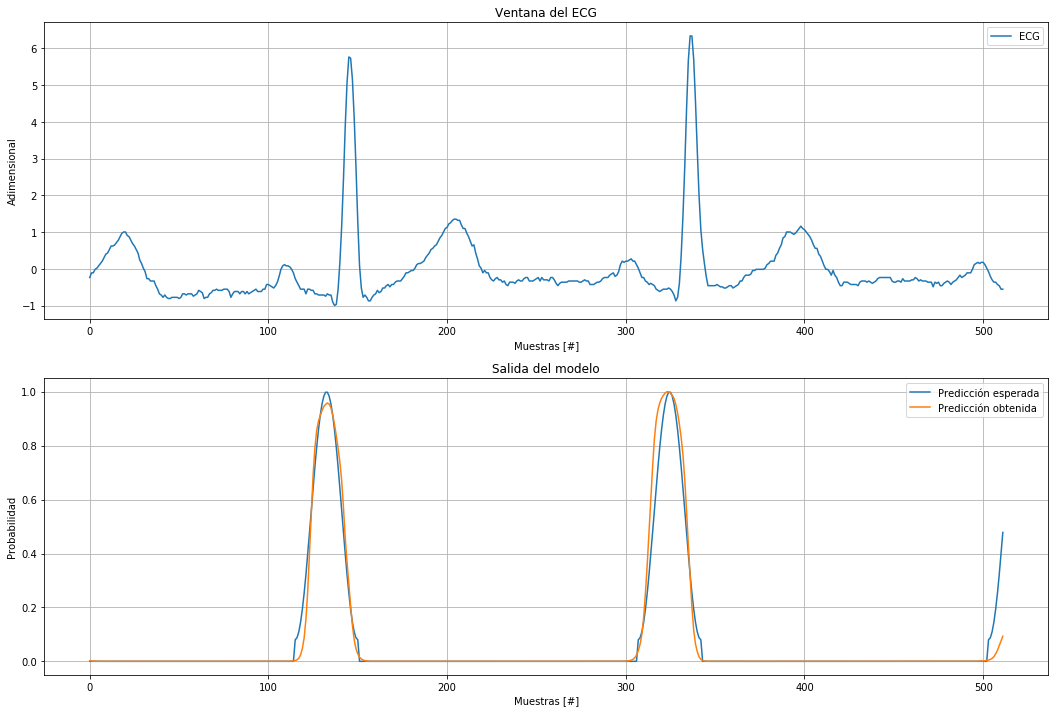

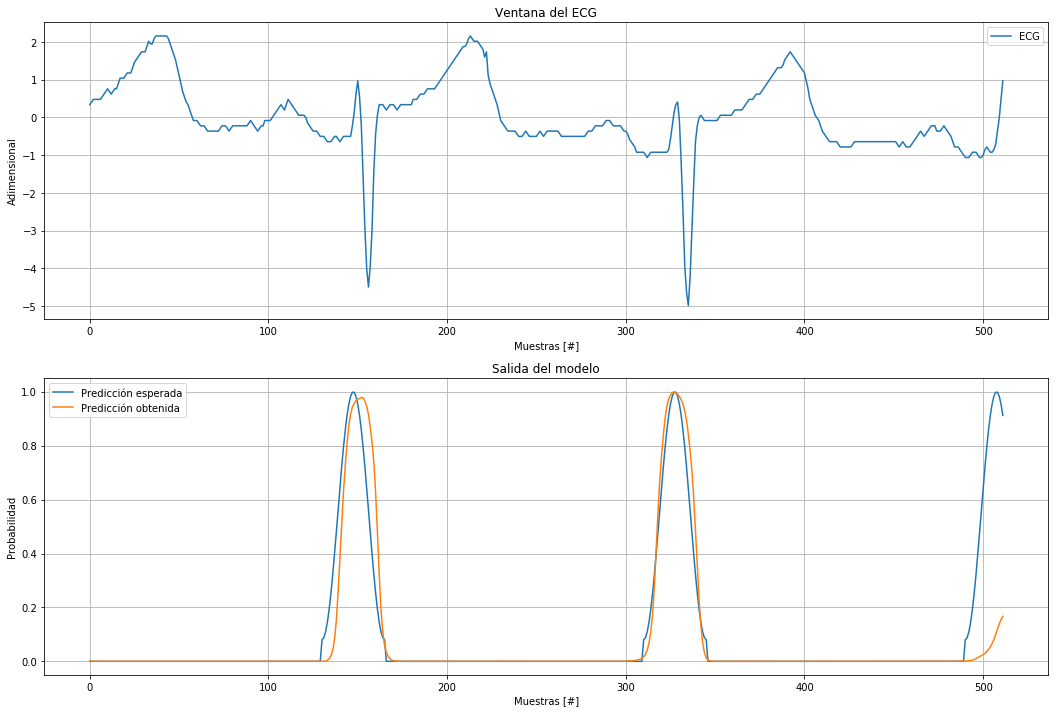

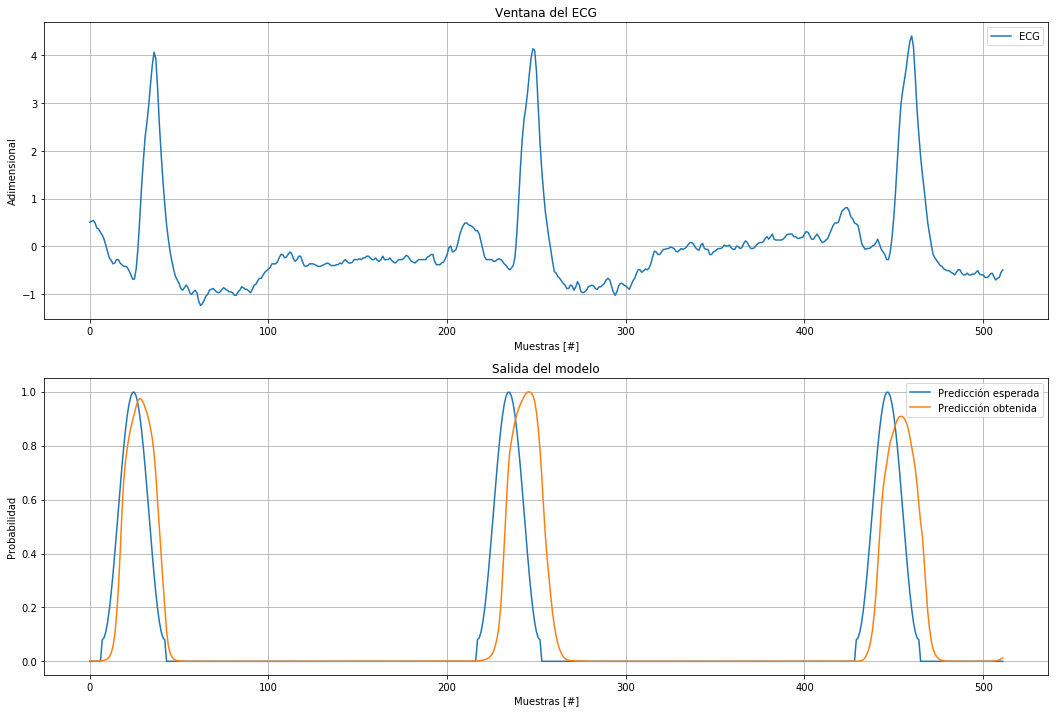

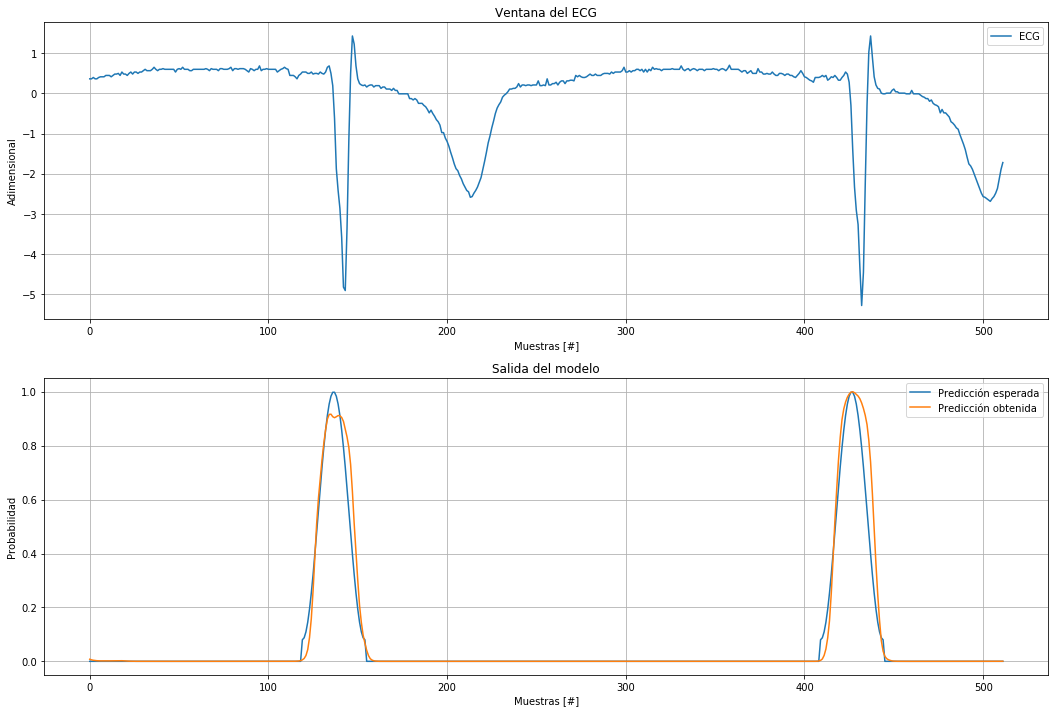

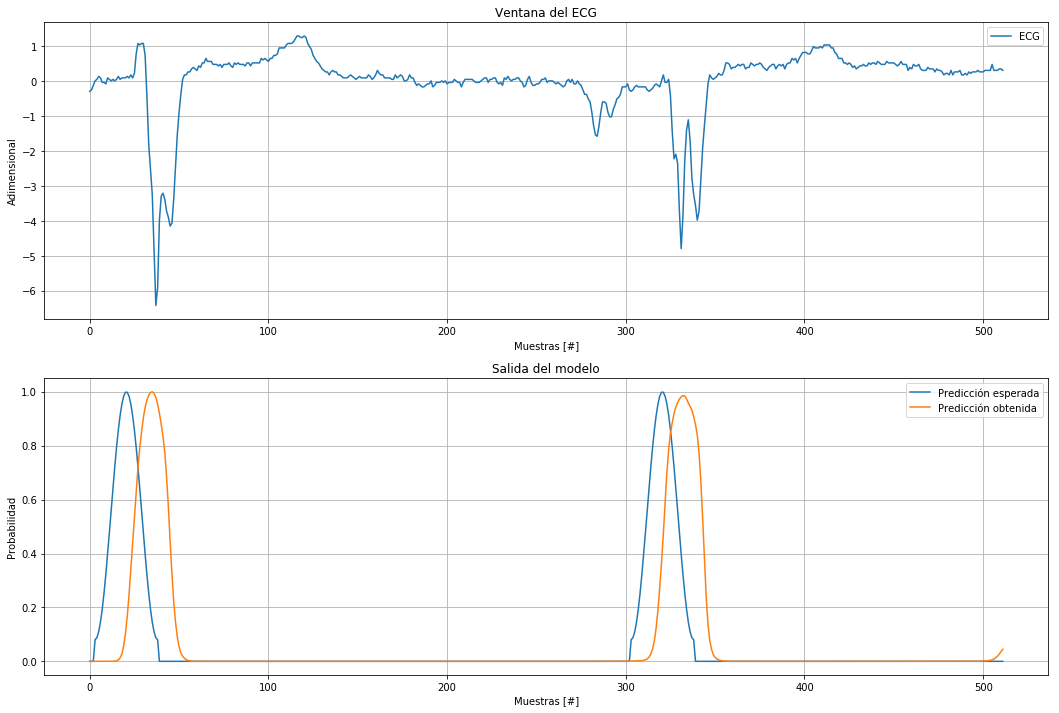

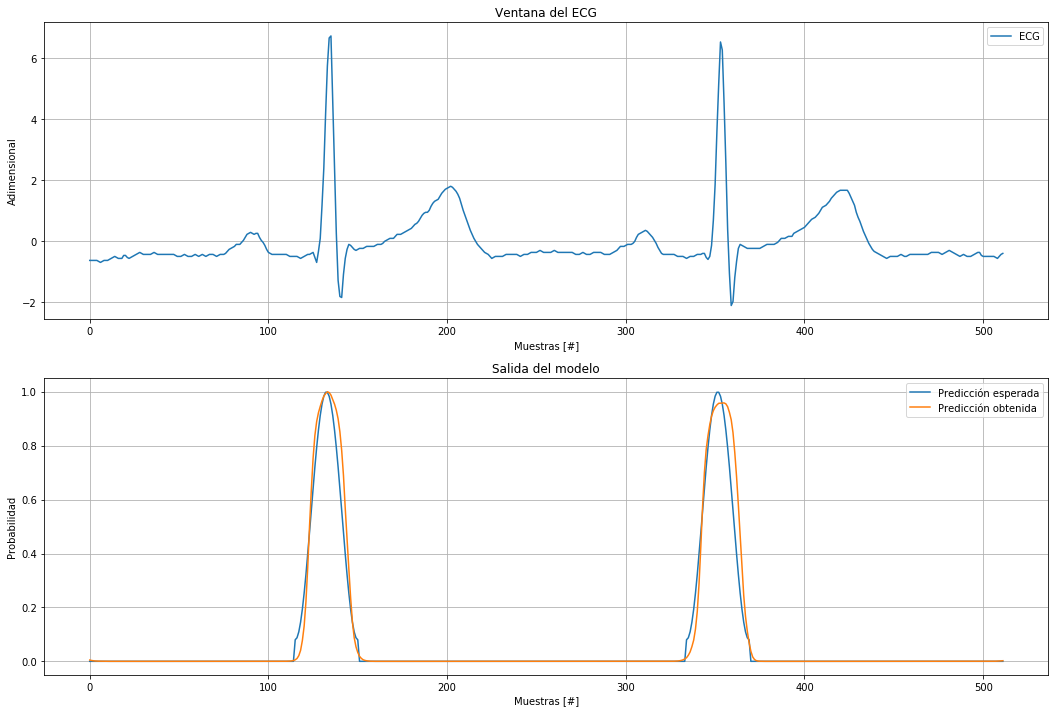

In [38]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod5', predictions)

In [39]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_5 = 100*verdadero_p/total
tasa_error_5 = 100*(falso_n + falso_p)/total
sensibilidad_5 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_5 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

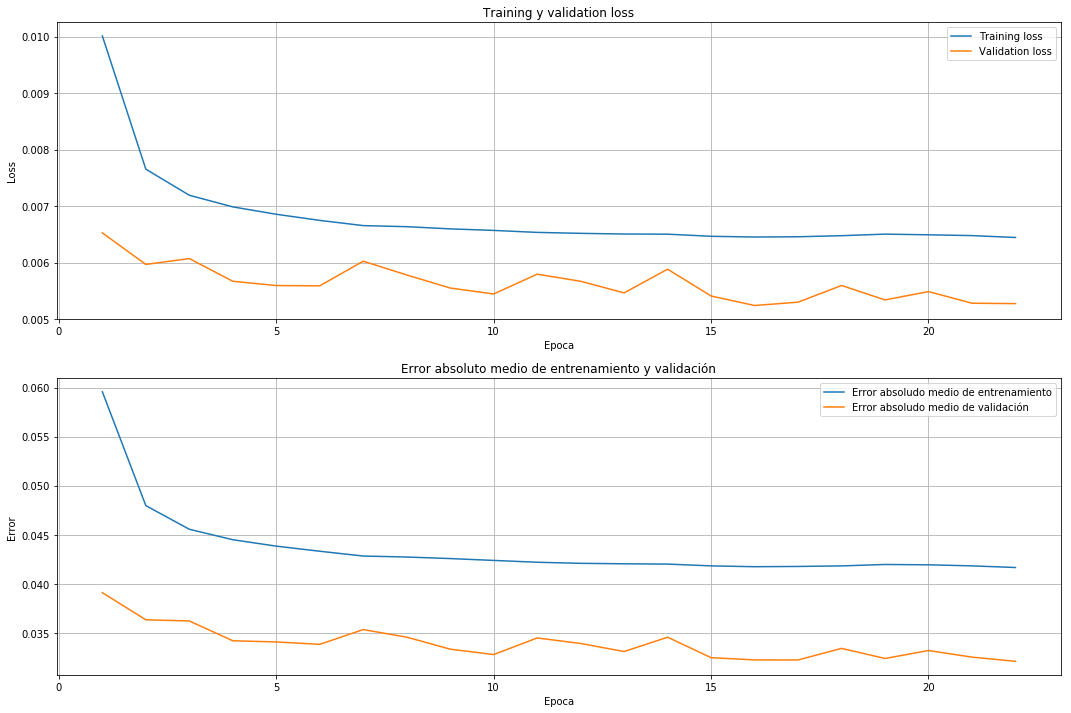

In [40]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

***
### Modelo 6

##### Arquitectura

In [41]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_50 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_50 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_51 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_51 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
average_pooling1d_8 (Average (None, 254, 16)           0         
__________

##### Configuración de red

In [42]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'logcosh',       # mean squared error
              metrics = ['mae', 'mse', 'accuracy'])  # mean absolute error

##### Entrenamiento

In [43]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

model.save('models/model6.h5')

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 443s 2ms/step - loss: 0.0101 - mean_absolute_error: 0.0599 - mean_squared_error: 0.0212 - acc: 0.0363 - val_loss: 0.0069 - val_mean_absolute_error: 0.0396 - val_mean_squared_error: 0.0144 - val_acc: 0.0322
Epoch 2/1000
203464/203464 [==============================] - 436s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0474 - mean_squared_error: 0.0157 - acc: 0.0432 - val_loss: 0.0069 - val_mean_absolute_error: 0.0395 - val_mean_squared_error: 0.0144 - val_acc: 0.0279
Epoch 3/1000
203464/203464 [==============================] - 443s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0449 - mean_squared_error: 0.0148 - acc: 0.0463 - val_loss: 0.0063 - val_mean_absolute_error: 0.0366 - val_mean_squared_error: 0.0131 - val_acc: 0.0379
Epoch 4/1000
203464/203464 [==============================] - 438s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0437 - mean_squared_error: 0.

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

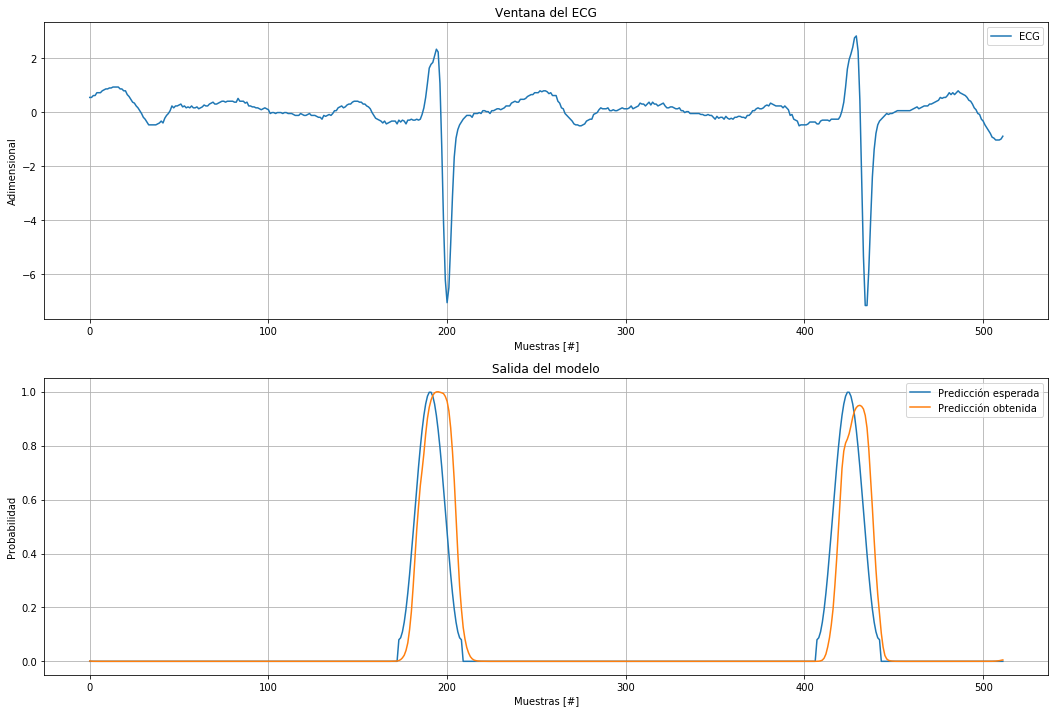

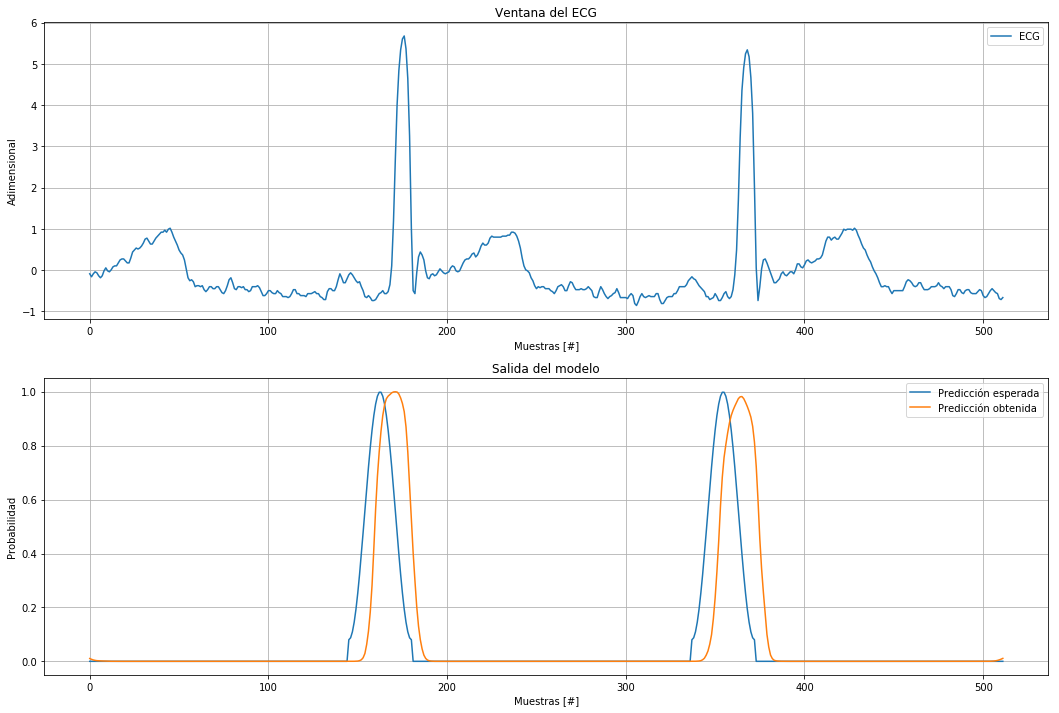

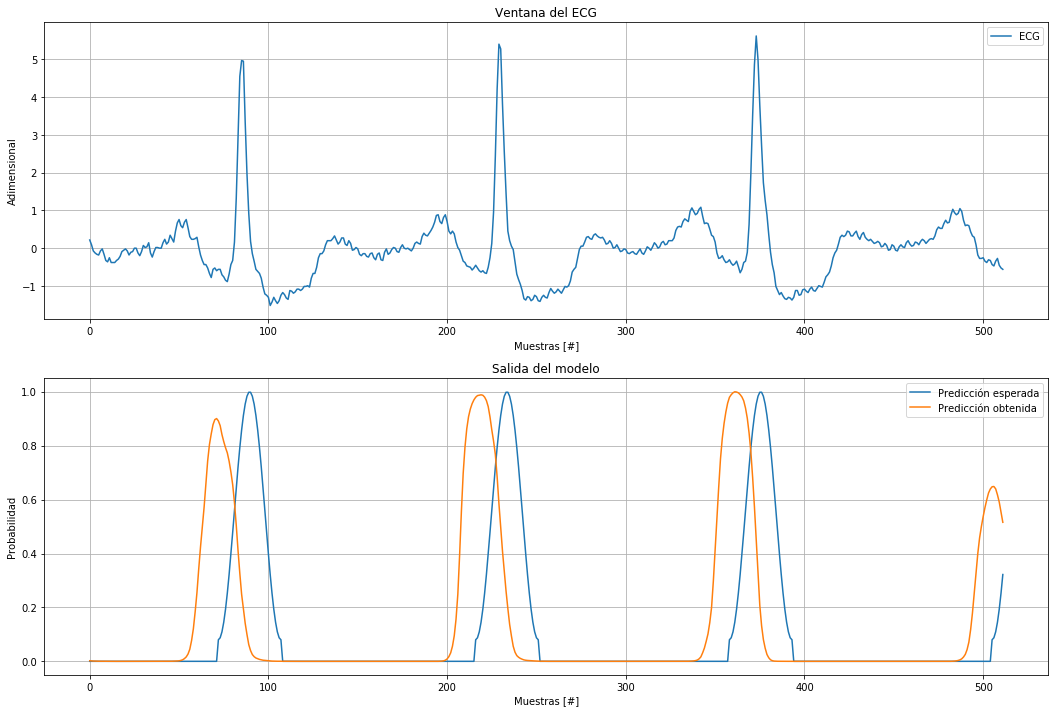

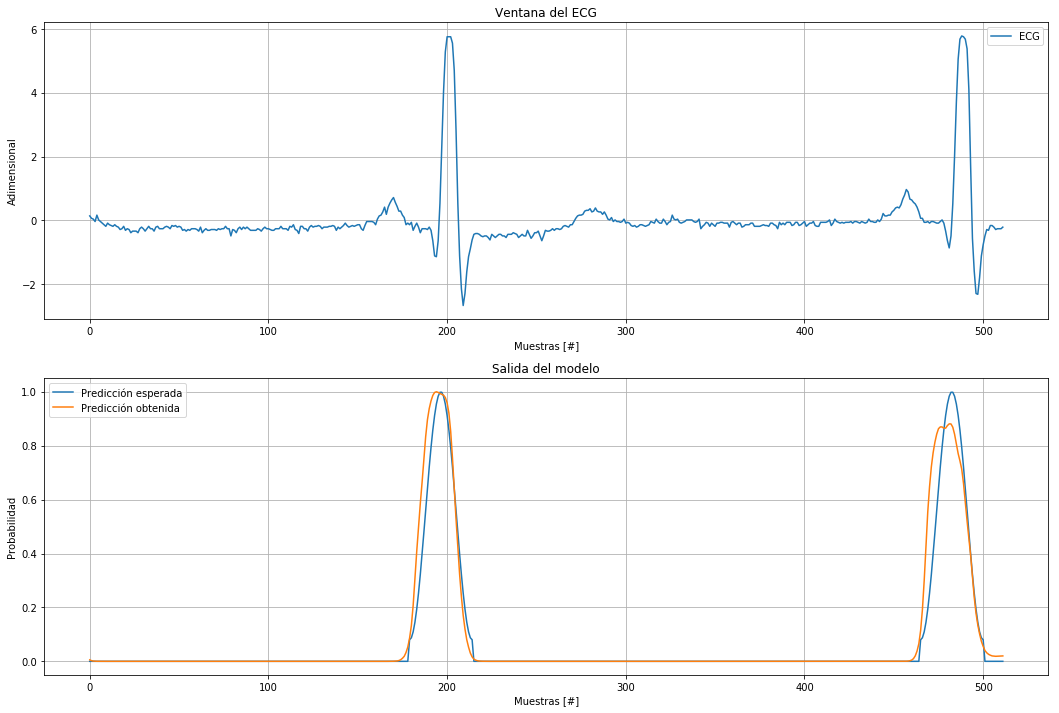

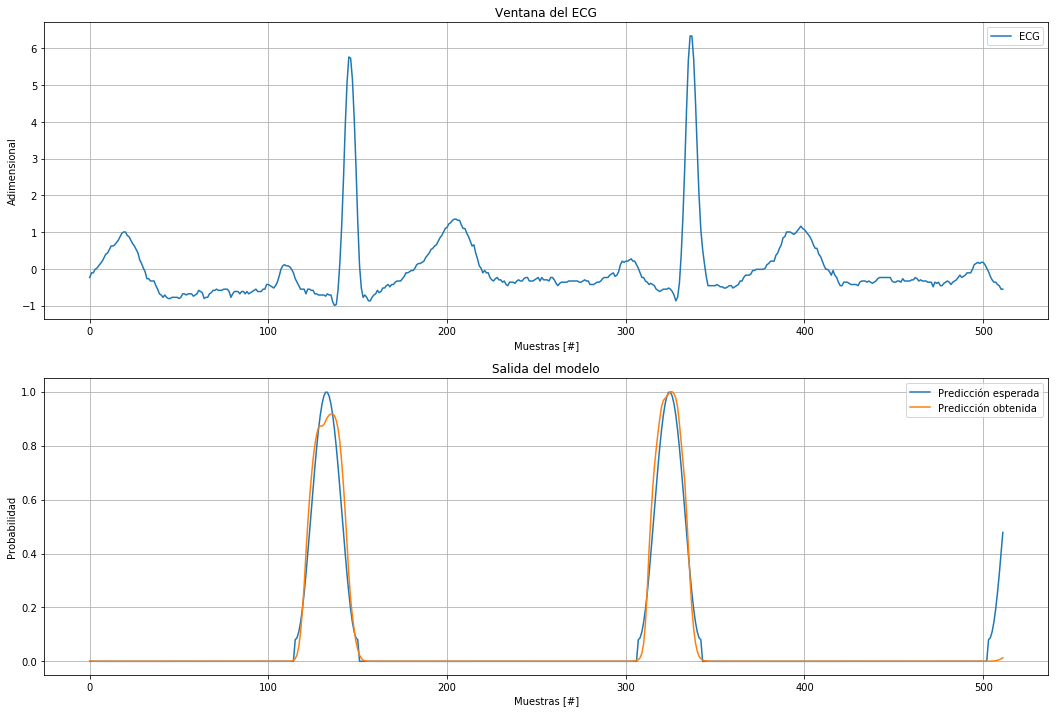

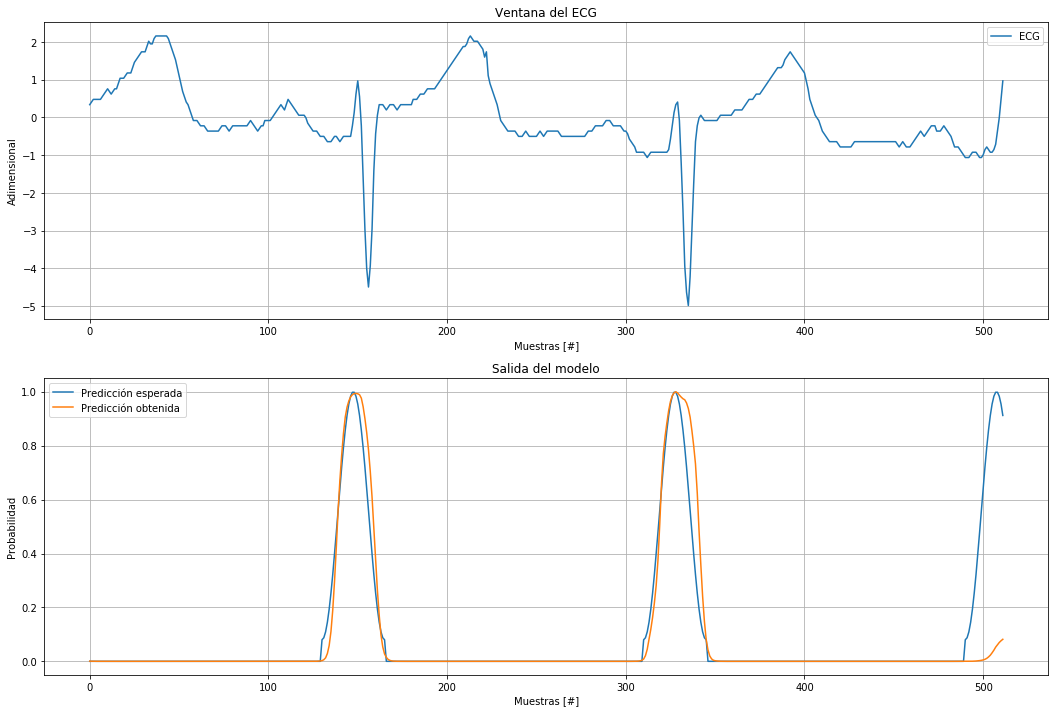

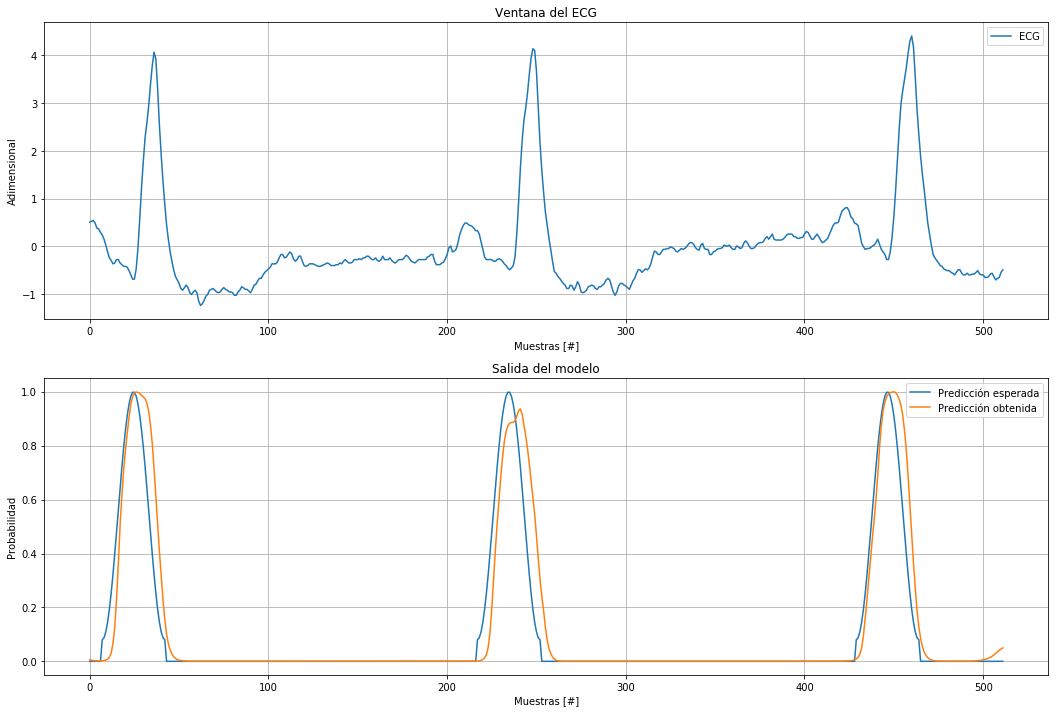

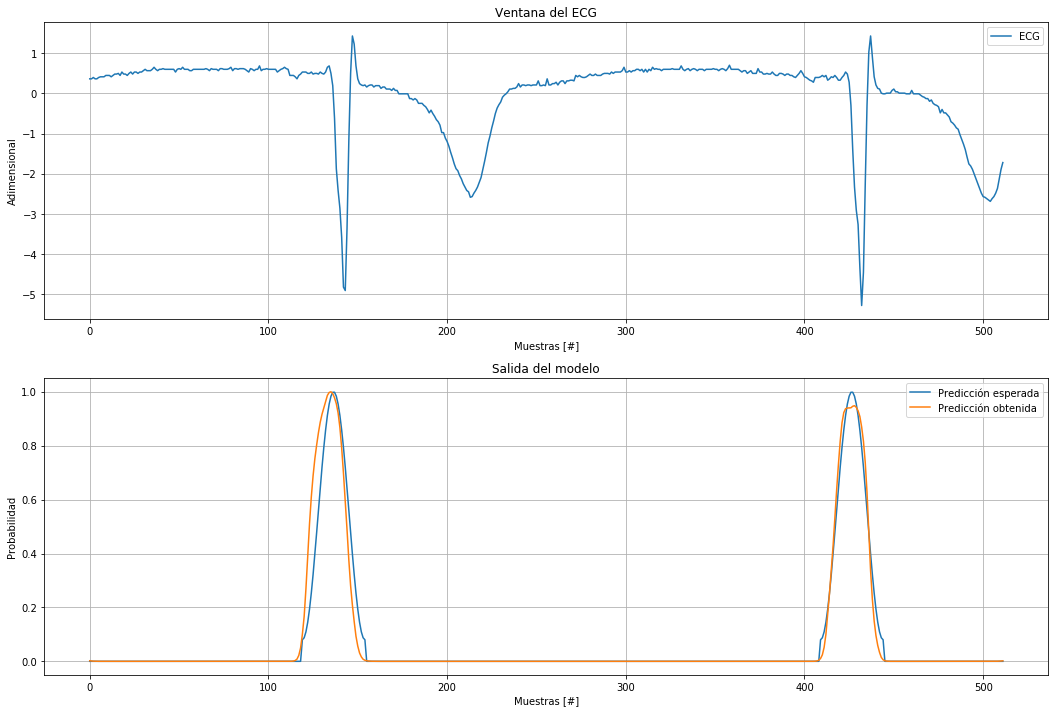

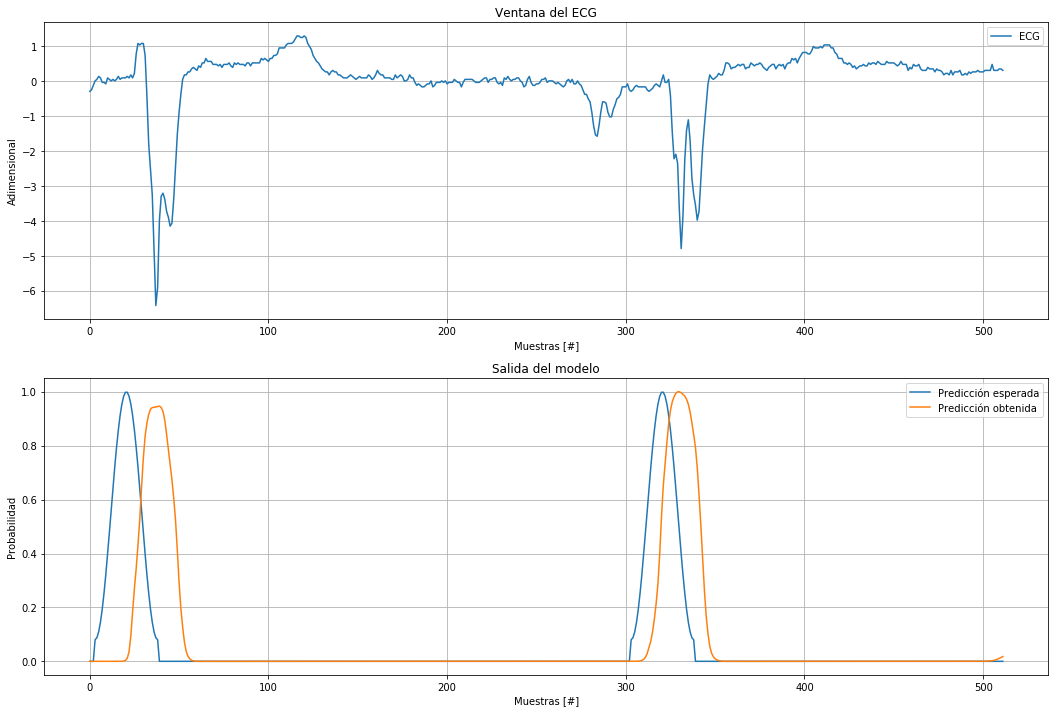

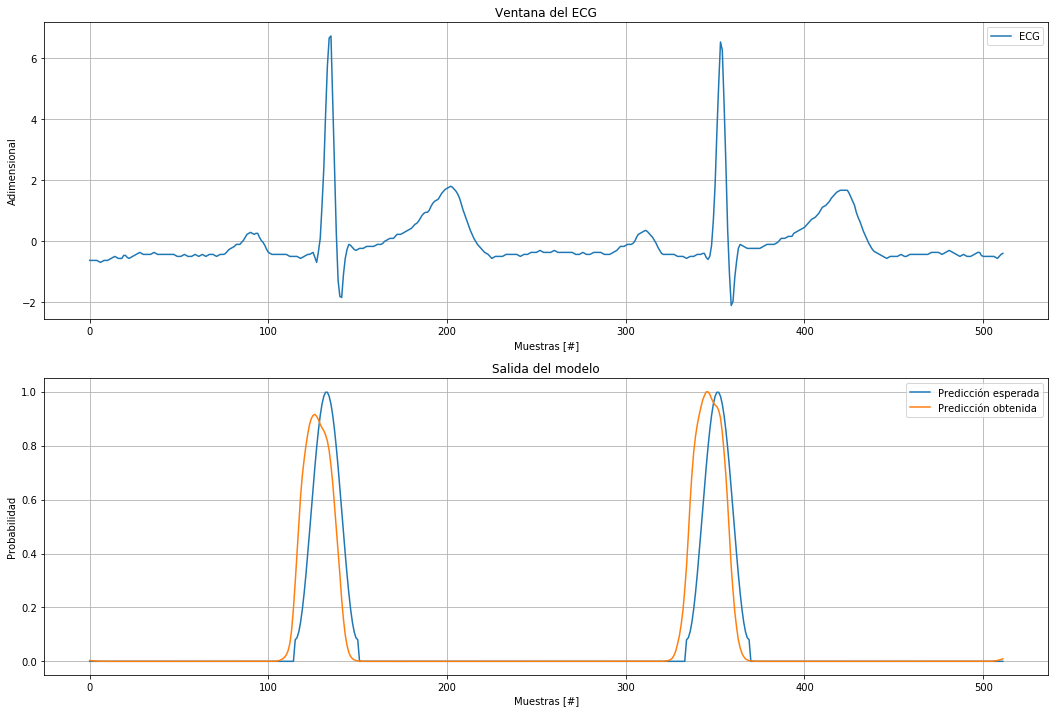

In [45]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod6', predictions)

In [46]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_6 = 100*verdadero_p/total
tasa_error_6 = 100*(falso_n + falso_p)/total
sensibilidad_6 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_6 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

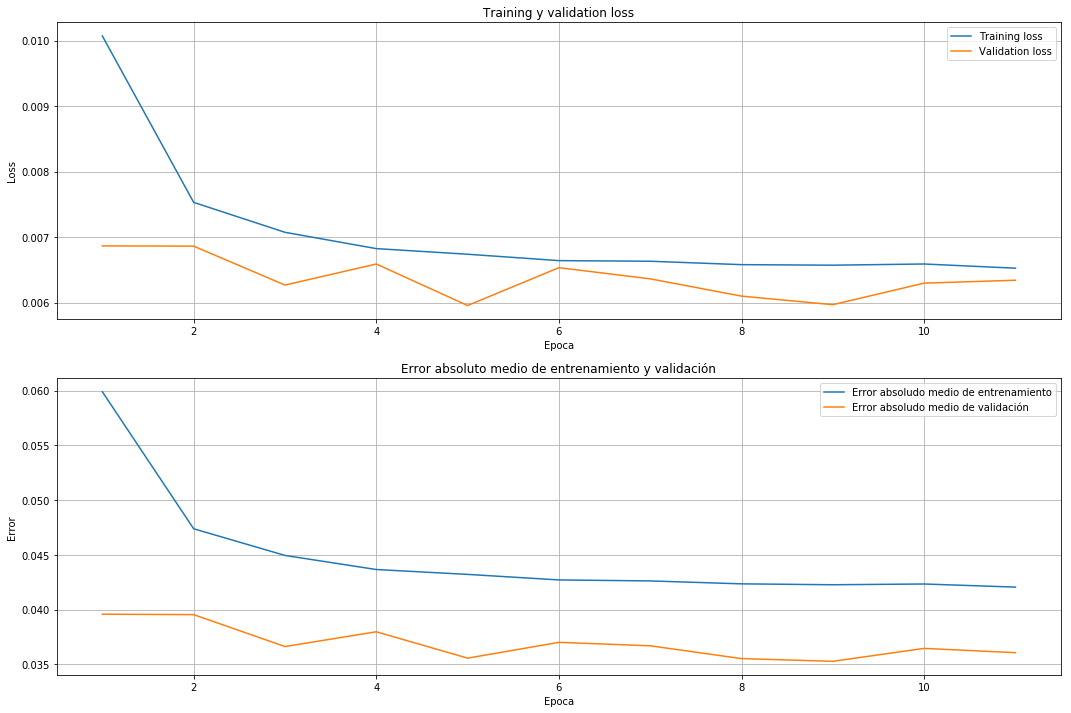

In [47]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

### Comparación de desempeño

In [51]:
tus_resultados = [  
                   [acc_1, tasa_error_1, sensibilidad_1, f1_1],
                   [acc_2, tasa_error_2, sensibilidad_2, f1_2],
                   [acc_3, tasa_error_3, sensibilidad_3, f1_3],
                   [acc_4, tasa_error_4, sensibilidad_4, f1_4],
                   [acc_5, tasa_error_5, sensibilidad_5, f1_5],
                   [acc_6, tasa_error_6, sensibilidad_6, f1_6],
                 ]

df = DataFrame(tus_resultados, columns=['Accuracy', 'Tasa de error', 'Sensibilidad', 'F1 Score'],
               index=["Binary 8 MAX", "Binary 8 AVE", "MSE 8 MAX", "MSE 8 AVE", "Logcosh 8 MAX", "Logcosh 8 AVE"])
HTML(df.to_html())